# Evaluation

In [7]:
import sys
import os
import importlib

# set your working dir
work_dir = '/u/csanthirasegaran/IBL_foundation_model'
os.chdir(work_dir)
print('working dir: ', work_dir)

path = 'src'
sys.path.append(str(path))

from src.loader.make_loader import make_loader
from src.utils.dataset_utils import load_ibl_dataset
from src.utils.utils import set_seed, move_batch_to_device, plot_gt_pred, metrics_list, plot_avg_rate_and_spike, \
    plot_rate_and_spike
from src.utils.config_utils import config_from_kwargs, update_config
from src.models.stpatch import STPatch
from src.models.ndt1 import NDT1
from src.models.neurotoken import Neurotokenizer
from src.trainer.make import make_trainer
from src.utils.eval_utils import (
    heldout_mask, 
    neg_log_likelihood,
    # create_behave_list,
    bits_per_spike,
    plot_psth,
    plot_single_trial_activity,
    viz_single_cell,
    viz_single_cell_unaligned,
    _add_baseline,
    raster_plot,
    compute_PSTH,
    compute_all_psth,
    compute_R2_psth,
    compute_R2_main
)

working dir:  /u/csanthirasegaran/IBL_foundation_model


In [8]:
import pickle
from math import ceil
from accelerate import Accelerator
from datasets import load_dataset, load_from_disk, concatenate_datasets, DatasetDict
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import r2_score
from scipy.special import gammaln
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.colors as colors
import os
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, r2_score

NAME2MODEL = {"STPatch": STPatch, "NDT1": NDT1, "Neurotoken": Neurotokenizer}

import logging

logger = logging.getLogger(__name__)

#### Helper Functions

In [9]:
# --------------------------------------------------------------------------------------------------
# Model/Dataset Loading and Configuration
# --------------------------------------------------------------------------------------------------

def load_model_data_local(**kwargs):
    model_config = kwargs['model_config']
    trainer_config = kwargs['trainer_config']
    model_path = kwargs['model_path']
    dataset_path = kwargs['dataset_path']
    test_size = kwargs['test_size']
    seed = kwargs['seed']
    mask_name = kwargs['mask_name']
    mask_mode = mask_name.split("_")[1]
    eid = kwargs['eid']
    stitching = kwargs['stitching']
    num_sessions = kwargs['num_sessions']
    tokenize_binary_mask = kwargs['tokenize_binary_mask']

    # set seed
    set_seed(seed)

    # load the model
    config = config_from_kwargs({"model": f"include:{model_config}"})
    config = update_config(model_config, config)
    config = update_config(trainer_config, config)
    config.model.encoder.masker.mode = mask_mode

    accelerator = Accelerator()

    train_dataset, val_dataset, test_dataset, meta_data = load_ibl_dataset(
                            cache_dir=config.dirs.dataset_cache_dir,
                            user_or_org_name="ibl-foundation-model",
                            num_sessions=config.data.num_sessions,
                            split_method=config.data.split_method,
                            train_session_eid=[eid],
                            test_session_eid=config.data.test_session_eid,
                            batch_size=config.training.train_batch_size,
                            seed=seed,
                            eid=None,
                        )
    
    meta_data["tokenize_binary_mask"] = True if tokenize_binary_mask else False

    # load the dataset
    dataset = load_dataset(f'ibl-foundation-model/{eid}_aligned', cache_dir=config.dirs.dataset_cache_dir)["test"]

    n_neurons = len(dataset['cluster_regions'][0])

    if config.model.model_class in ["NDT1", "iTransformer"]:
        max_space_length = n_neurons  
    elif config.model.model_class in ["NDT2", "STPatch"]:
        # max_space_length = config.model.encoder.embedder.n_neurons
        max_space_F = config.model.encoder.embedder.max_space_F
        max_num_neurons = max(meta_data['num_neurons'])
        max_space_length = ceil(max_num_neurons/max_space_F) * max_space_F
    else:
        max_space_length = config.data.max_space_length

    meta_data['max_space_length'] = max_space_length

    print('encoder max space length:', max_space_length)
    
    print(meta_data)

    model_class = NAME2MODEL[config.model.model_class]
    model = model_class(config.model, **config.method.model_kwargs, **meta_data)    
    model = torch.load(model_path, map_location=torch.device('cpu'))['model']

    model.encoder.masker.mode = mask_mode
    model.encoder.masker.force_active = False

    print("(eval) masking mode: ", model.encoder.masker.mode)
    print("(eval) masking ratio: ", model.encoder.masker.ratio)
    print("(eval) masking active: ", model.encoder.masker.force_active)
    if 'causal' in mask_name:
        model.encoder.context_forward = 0
        print("(behave decoding) context forward: ", model.encoder.context_forward)
    
    model = accelerator.prepare(model)

    dataloader = make_loader(
        dataset,
        target=config.data.target,
        batch_size=len(dataset),
        pad_to_right=True,
        pad_value=-1.,
        max_time_length=config.data.max_time_length,
        max_space_length=max_space_length,
        dataset_name=config.data.dataset_name,
        load_meta=config.data.load_meta,
        shuffle=False,
    )

    # check the shape of the dataset
    for batch in dataloader:
        print('spike data shape: {}'.format(batch['spikes_data'].shape))
        break

    return model, accelerator, dataset, dataloader

# --------------------------------------------------------------------------------------------------
# Evaluation
# 1. Co-smoothing_eval (R2, co-bps, and shuqi's plot) 
# 2. Behavior_decoding (choice, wheel speed)
# 3. R2 scatter plot
# --------------------------------------------------------------------------------------------------

def co_smoothing_eval(
        model,
        accelerator,
        test_dataloader,
        test_dataset,
        n=1,
        save_plot=False,
        **kwargs
):
    assert n == 1, 'only support n=1 now'

    for batch in test_dataloader:
        break

    method_name = kwargs['method_name']
    mode = kwargs['mode']
    is_aligned = kwargs['is_aligned']
    target_regions = kwargs['target_regions']
    n_jobs = kwargs['n_jobs']

    # hack to accommodate NDT2 - fix later 
    if sum(batch['space_attn_mask'][0] == 0) == 0:
        tot_num_neurons = batch['space_attn_mask'].size()[-1]
    else:
        tot_num_neurons = (batch['space_attn_mask'][0] == 0).nonzero().min().item() 
    uuids_list = np.array(test_dataset['cluster_uuids'][0])[:tot_num_neurons]
    region_list = np.array(test_dataset['cluster_regions'])[0][:tot_num_neurons]

    T = kwargs['n_time_steps']
    N = uuids_list.shape[0]    

    if is_aligned:
        
        # prepare the condition matrix
        b_list = []
    
        # choice
        choice = np.array(test_dataset['choice'])
        choice = np.tile(np.reshape(choice, (choice.shape[0], 1)), (1, T))
        b_list.append(choice)
    
        # reward
        reward = np.array(test_dataset['reward'])
        reward = np.tile(np.reshape(reward, (reward.shape[0], 1)), (1, T))
        b_list.append(reward)
    
        # block
        block = np.array(test_dataset['block'])
        block = np.tile(np.reshape(block, (block.shape[0], 1)), (1, T))
        b_list.append(block)
    
        behavior_set = np.stack(b_list, axis=-1)
    
        var_name2idx = {'block': [2],
                        'choice': [0],
                        'reward': [1],
                        'wheel': [3],
                        }
        var_value2label = {'block': {(0.2,): "p(left)=0.2",
                                     (0.5,): "p(left)=0.5",
                                     (0.8,): "p(left)=0.8", },
                           'choice': {(-1.0,): "right",
                                      (1.0,): "left"},
                           'reward': {(0.,): "no reward",
                                      (1.,): "reward", }}
        var_tasklist = ['block', 'choice', 'reward']
        var_behlist = []

    if mode == 'per_neuron':

        gt_result_list, pred_result_list = [], []
        bps_result_list, r2_result_list = [float('nan')] * tot_num_neurons, [np.array([np.nan, np.nan])] * N
        # loop through all the neurons
        # for n_i in tqdm(range(tot_num_neurons)):
        bps_per_region = []; region = 'CA1'
        for n_i in tqdm(np.argwhere(region_list == region).flatten()):
            model.eval()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = move_batch_to_device(batch, accelerator.device)     
                        
                    mask_result = heldout_mask(
                        batch['spikes_data'].clone(),
                        mode='manual',
                        heldout_idxs=np.array([n_i])
                    )
                    try:
                        masking_mode = 'neuron' if model.use_prompt else model.encoder.masker.mode
                        model.encoder.mask = False
                    except AttributeError:
                        masking_mode = 'neuron' if model.use_prompt else model.masker.mode
                        model.mask = False
                    
                    outputs = model(
                        mask_result['spikes'],
                        time_attn_mask=batch['time_attn_mask'],
                        space_attn_mask=batch['space_attn_mask'],
                        spikes_timestamps=batch['spikes_timestamps'], 
                        spikes_spacestamps=batch['spikes_spacestamps'], 
                        targets = batch['target'],
                        neuron_regions=batch['neuron_regions'],
                        eval_mask=mask_result['eval_mask'],
                        masking_mode = masking_mode,
                        num_neuron=batch['spikes_data'].shape[2],
                        eid=batch['eid'][0],
                    )
            outputs.preds = torch.exp(outputs.preds)
    
            gt_spikes = batch['spikes_data'].detach().cpu().numpy()
            pred_spikes = outputs.preds.detach().cpu().numpy()

            # compute co-bps
            gt_held_out = gt_spikes[:, :, [n_i]]
            pred_held_out = pred_spikes[:, :, [n_i]]

            bps = bits_per_spike(pred_held_out, gt_held_out)
            if np.isinf(bps):
                bps = np.nan
            bps_result_list[n_i] = bps
            bps_per_region.append(bps)

            gt_result_list.append(gt_held_out)
            pred_result_list.append(pred_held_out)

            # compute R2
            if is_aligned:
                X = behavior_set  # [#trials, #timesteps, #variables]
                _r2_psth, _r2_trial = viz_single_cell(X, gt_held_out.squeeze(), pred_held_out.squeeze(),
                                                      var_name2idx, var_tasklist, var_value2label, var_behlist,
                                                      subtract_psth=kwargs['subtract'],
                                                      aligned_tbins=kwargs['onset_alignment'],
                                                      neuron_idx=uuids_list[n_i][:4],
                                                      neuron_region=region_list[n_i],
                                                      method=method_name, save_path=kwargs['save_path'],
                                                      save_plot=save_plot
                                                     )
                r2_result_list[n_i] = np.array([_r2_psth, _r2_trial])
            else:
                r2 = viz_single_cell_unaligned(
                    gt_held_out.squeeze(), pred_held_out.squeeze(), 
                    neuron_idx=uuids_list[n_i][:4],
                    neuron_region=region_list[n_i],
                    method=method_name, save_path=kwargs['save_path'],
                    save_plot=save_plot
                )
                r2_result_list[n_i] = r2
                
        print(f'{region} bps: ', np.nanmean(bps_per_region))

    elif mode == 'inter_region':

        if 'all' in target_regions:
            target_regions = list(np.unique(region_list))
            
        held_out_list = kwargs['held_out_list']

        assert held_out_list is None, 'inter_region does LOO for all neurons in the target region'

        gt_result_list, pred_result_list = [], []
        y_list, y_pred_list, y_residual_list = [], [], []
        bps_result_list, r2_result_list = [float('nan')] * tot_num_neurons, [np.array([np.nan, np.nan])] * N
        for region in tqdm(target_regions, desc='region'):
            print(region)
            hd = np.argwhere(region_list==region).flatten() 
            held_out_list = np.arange(len(hd))
            held_out_list = [held_out_list]   
            hd = np.array([held_out_list]).flatten()

            model.eval()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = move_batch_to_device(batch, accelerator.device)       
                        
                    gt_spike_data = batch['spikes_data'].clone()
                    mask_result = heldout_mask(
                        batch['spikes_data'].clone(),
                        mode=mode,
                        heldout_idxs=hd,
                        target_regions=[region],
                        neuron_regions=region_list
                    )              

                    try:
                        masking_mode = 'inter-region' if model.use_prompt else model.encoder.masker.mode
                        model.encoder.mask = False
                    except AttributeError:
                        masking_mode = 'inter-region' if model.use_prompt else model.masker.mode
                        model.mask = False
                    
                    outputs = model(
                        mask_result['spikes'],
                        time_attn_mask=batch['time_attn_mask'],
                        space_attn_mask=batch['space_attn_mask'],
                        spikes_timestamps=batch['spikes_timestamps'], 
                        spikes_spacestamps=batch['spikes_spacestamps'], 
                        targets = batch['target'],
                        neuron_regions=batch['neuron_regions'],
                        eval_mask=mask_result['eval_mask'],
                        masking_mode=masking_mode,
                        num_neuron=batch['spikes_data'].shape[2],
                        eid=batch['eid'][0],
                    )
            outputs.preds = torch.exp(outputs.preds)
        
            gt_spikes = gt_spike_data.detach().cpu().numpy()
            pred_spikes = outputs.preds.detach().cpu().numpy()
    
            target_neuron_idxs = mask_result['heldout_idxs']
            target_time_idxs = np.arange(gt_spikes.shape[1])

            # compute co-bps
            gt_held_out = gt_spikes[:, target_time_idxs][:,:,target_neuron_idxs]
            pred_held_out = pred_spikes[:, target_time_idxs][:,:,target_neuron_idxs]

            bps_per_region = []
            for n_i in range(len(target_neuron_idxs)): 
                bps = bits_per_spike(pred_held_out[:,:,[n_i]], gt_held_out[:,:,[n_i]])
                if np.isinf(bps):
                    bps = np.nan
                bps_result_list[target_neuron_idxs[n_i]] = bps
                bps_per_region.append(bps)
            bps_per_region = [bits_per_spike(pred_held_out, gt_held_out)]
            print(f'{region} bps: ', np.nanmean(bps_per_region))

            # compute R2
            ys = gt_spikes[:, target_time_idxs]
            y_preds = pred_spikes[:, target_time_idxs]
    
            # choose the neuron to plot
            idxs = target_neuron_idxs
            for i in range(idxs.shape[0]):

                gt_result_list.append(ys[:, :, idxs[i]])
                pred_result_list.append(y_preds[:, :, idxs[i]])
            
                if is_aligned:
                    X = behavior_set[:, target_time_idxs, :]  # [#trials, #timesteps, #variables]
                    _r2_psth, _r2_trial, y, y_pred, y_residual = viz_single_cell(X, ys[:, :, idxs[i]], y_preds[:, :, idxs[i]],
                                                          var_name2idx, var_tasklist, var_value2label, var_behlist,
                                                          subtract_psth=kwargs['subtract'],
                                                          aligned_tbins=[],
                                                          neuron_idx=uuids_list[idxs[i]][:4],
                                                          neuron_region=region_list[idxs[i]],
                                                          method=method_name, save_path=kwargs['save_path'],
                                                          save_plot=save_plot
                                                         );
                    r2_result_list[idxs[i]] = np.array([_r2_psth, _r2_trial])

                    y_list.append(y)
                    y_pred_list.append(y_pred)
                    y_residual_list.append(y_residual)
                    
                else:
                    r2 = viz_single_cell_unaligned(
                        ys[:, :, idxs[i]], y_preds[:, :, idxs[i]], 
                        neuron_idx=uuids_list[idxs[i]][:4],
                        neuron_region=region_list[idxs[i]],
                        method=method_name, save_path=kwargs['save_path'],
                        save_plot=save_plot
                    )
                    r2_result_list[idxs[i]] = r2

            break
                        
    elif mode == 'intra_region':

        if 'all' in target_regions:
            target_regions = list(np.unique(region_list))
            
        held_out_list = kwargs['held_out_list']
        assert held_out_list is None, 'intra_region does LOO for all neurons in the target region'

        gt_result_list, pred_result_list = [], []
        y_list, y_pred_list, y_residual_list = [], [], []
        bps_result_list, r2_result_list = [float('nan')] * tot_num_neurons, [np.array([np.nan, np.nan])] * N
        for region in tqdm(target_regions, desc='region'):
            print(region)
            target_neuron_idxs = np.argwhere(region_list==region).flatten() 
            held_out_list = list(range(0, len(target_neuron_idxs)+n_jobs, n_jobs))

            bps_per_region = []
            
            for hd_idx in held_out_list:
                
                if hd_idx >= len(target_neuron_idxs):
                    break

                gt_spikes_lst, mask_spikes_lst, eval_mask_lst, heldout_idxs_lst = [], [], [], []
                time_attn_mask_lst, space_attn_mask_lst, spikes_timestamps_lst, spikes_spacestamps_lst, targets_lst, neuron_regions_lst, nemo_rep_lst = [], [], [], [], [], [], []
    
                model.eval()
                with torch.no_grad():
                    for batch in test_dataloader:
                        batch = move_batch_to_device(batch, accelerator.device)

                        gt_spike_data = batch['spikes_data'].clone()
                        for i in range(n_jobs):
                            if hd_idx+i < len(target_neuron_idxs):
                                mask_result = heldout_mask(
                                    batch['spikes_data'].clone(),
                                    mode=mode,
                                    heldout_idxs=np.array([hd_idx+i]).flatten(),
                                    target_regions=[region],
                                    neuron_regions=region_list
                                )   
                                mask_spikes_lst.append(mask_result['spikes'])
                                eval_mask_lst.append(mask_result['eval_mask'])
                                heldout_idxs_lst.append(mask_result['heldout_idxs'])
                                gt_spikes_lst.append(gt_spike_data)
                                time_attn_mask_lst.append(batch['time_attn_mask'])
                                space_attn_mask_lst.append(batch['space_attn_mask'])
                                spikes_timestamps_lst.append(batch['spikes_timestamps'])
                                spikes_spacestamps_lst.append(batch['spikes_spacestamps'])
                                targets_lst.append(batch['target'])
                                neuron_regions_lst.append(batch['neuron_regions'])
                            else:
                                break

                        try:
                            masking_mode = 'intra-region' if model.use_prompt else model.encoder.masker.mode
                            model.encoder.mask = False
                        except AttributeError:
                            masking_mode = 'intra-region' if model.use_prompt else model.masker.mode
                            model.mask = False
                        
                        outputs = model(
                            torch.cat(mask_spikes_lst, 0),
                            time_attn_mask=torch.cat(time_attn_mask_lst, 0),
                            space_attn_mask=torch.cat(space_attn_mask_lst, 0),
                            spikes_timestamps=torch.cat(spikes_timestamps_lst, 0), 
                            spikes_spacestamps=torch.cat(spikes_spacestamps_lst, 0), 
                            targets = torch.cat(targets_lst, 0),
                            neuron_regions=np.stack(neuron_regions_lst, axis=-1).squeeze(),
                            eval_mask=torch.cat(eval_mask_lst, 0),
                            masking_mode=masking_mode,
                            num_neuron=batch['spikes_data'].shape[2],
                            eid=batch['eid'][0],
                        )
                outputs.preds = torch.exp(outputs.preds)
            
                gt_spikes = torch.cat(gt_spikes_lst, 0).detach().cpu().numpy()
                pred_spikes = outputs.preds.detach().cpu().numpy()
                tot_num_trials = len(batch['spikes_data'])

                heldout_idxs = np.stack(heldout_idxs_lst).flatten()
                
                for i in range(len(heldout_idxs)):
                    gt_held_out = gt_spikes[i*tot_num_trials:(i+1)*tot_num_trials, :, [heldout_idxs[i]]]
                    pred_held_out = pred_spikes[i*tot_num_trials:(i+1)*tot_num_trials, :, [heldout_idxs[i]]]
    
                    # bps = bits_per_spike(pred_held_out, gt_held_out)
                    # if np.isinf(bps):
                    #     bps = np.nan
                    # bps_result_list[heldout_idxs[i]] = bps
                    # bps_per_region.append(bps)

                    gt_result_list.append(gt_held_out.squeeze())
                    pred_result_list.append(pred_held_out.squeeze())

                    if is_aligned:
                        X = behavior_set  # [#trials, #timesteps, #variables]
                        _r2_psth, _r2_trial, y, y_pred, y_residual = viz_single_cell(X, gt_held_out.squeeze(), pred_held_out.squeeze(),
                                                              var_name2idx, var_tasklist, var_value2label, var_behlist,
                                                              subtract_psth=kwargs['subtract'],
                                                              aligned_tbins=[],
                                                              neuron_idx=uuids_list[heldout_idxs[i]][:4],
                                                              neuron_region=region_list[heldout_idxs[i]],
                                                              method=method_name, save_path=kwargs['save_path'],
                                                              save_plot=save_plot
                                                             );
                        r2_result_list[heldout_idxs[i]] = np.array([_r2_psth, _r2_trial])
                        y_list.append(y)
                        y_pred_list.append(y_pred)
                        y_residual_list.append(y_residual)
                    else:
                        r2 = viz_single_cell_unaligned(
                            gt_held_out.squeeze(), pred_held_out.squeeze(),
                            neuron_idx=uuids_list[heldout_idxs[i]][:4],
                            neuron_region=region_list[heldout_idxs[i]],
                            method=method_name, save_path=kwargs['save_path'],
                            save_plot=save_plot
                        )
                        r2_result_list[heldout_idxs[i]] = r2

            bps_per_region = [bits_per_spike(
                np.array(pred_result_list).transpose(1,2,0), 
                np.array(gt_result_list).transpose(1,2,0)
            )]
            print(f'{region} bps: ', np.nanmean(bps_per_region))
    else:
        raise NotImplementedError('mode not implemented')

    # save co-bps
    os.makedirs(kwargs['save_path'], exist_ok=True)
    bps_all = np.array(bps_result_list)
    bps_mean = np.nanmean(bps_all)
    bps_std = np.nanstd(bps_all)
    np.save(os.path.join(kwargs['save_path'], f'bps.npy'), bps_all)
    
    # save R2
    r2_all = np.array(r2_result_list)
    np.save(os.path.join(kwargs['save_path'], f'r2.npy'), r2_all)

    return gt_result_list, pred_result_list, behavior_set, y_list, y_pred_list, y_residual_list

In [10]:
# --------------------------------------------------------------------------------------------------
# single neuron plot functions
# --------------------------------------------------------------------------------------------------

"""
:X: [n_trials, n_timesteps, n_variables]
:y: [n_trials, n_timesteps] (in Hz)
:y_pred: [n_trials, n_timesteps] (in Hz)
:var_tasklist: for each task variable in var_tasklists, compute PSTH
:var_name2idx: for each task variable in var_tasklists, the corresponding index of X
:var_value2label:
:aligned_tbins: reference time steps to annotate. 
"""


def plot_psth(X, y, y_pred, var_tasklist, var_name2idx, var_value2label,
              aligned_tbins=[],
              axes=None, legend=False, neuron_idx='', neuron_region='', save_plot=False):
    
    if save_plot:
        if axes is None:
            nrows = 1;
            ncols = len(var_tasklist)
            fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 2 * nrows))

        for ci, var in enumerate(var_tasklist):
            ax = axes[ci]
            psth_xy = compute_all_psth(X, y, var_name2idx[var])
            psth_pred_xy = compute_all_psth(X, y_pred, var_name2idx[var])
            
            for _i, _x in enumerate(psth_xy.keys()):
                psth = psth_xy[_x]
                psth_pred = psth_pred_xy[_x]
                ax.plot(psth,
                        color=plt.get_cmap('tab10')(_i),
                        linewidth=3, alpha=0.3, label=f"{var}: {tuple(_x)[0]:.2f}")
                ax.plot(psth_pred,
                        color=plt.get_cmap('tab10')(_i),
                        linestyle='--')
                ax.set_xlabel("Time bin")
                if ci == 0:
                    ax.set_ylabel("Neural activity")
                else:
                    ax.sharey(axes[0])
            _add_baseline(ax, aligned_tbins=aligned_tbins)
            if legend:
                ax.legend()
                ax.set_title(f"{var}")

    # compute PSTH for task_contingency
    idxs_psth = np.concatenate([var_name2idx[var] for var in var_tasklist])
    psth_xy = compute_all_psth(X, y, idxs_psth)
    psth_pred_xy = compute_all_psth(X, y_pred, idxs_psth)
    r2_psth = compute_R2_psth(psth_xy, psth_pred_xy, clip=False)
    r2_single_trial = compute_R2_main(y.reshape(-1, 1), y_pred.reshape(-1, 1), clip=False)[0]
    
    if save_plot:
        axes[0].set_ylabel(
            f'Neuron: #{neuron_idx[:4]} \n PSTH R2: {r2_psth:.2f} \n Avg_SingleTrial R2: {r2_single_trial:.2f}')

        for ax in axes:
            # ax.axis('off')
            ax.spines[['right', 'top']].set_visible(False)
            # ax.set_frame_on(False)
            # ax.tick_params(bottom=False, left=False)
        plt.tight_layout()

    return r2_psth, r2_single_trial


"""
:X: [n_trials, n_timesteps, n_variables]
:y: [n_trials, n_timesteps] (in Hz)
:y_pred: [n_trials, n_timesteps] (in Hz)
:var_tasklist: variables used for computing the task-condition-averaged psth if subtract_psth=='task'
:var_name2idx:
:var_tasklist: variables to be plotted in the single-trial behavior
:subtract_psth: 
    - None: no subtraction
    - "task": subtract task-condition-averaged psth
    - "global": subtract global-averaged psth
:aligned_tbins: reference time steps to annotate. 
:nclus, n_neighbors: hyperparameters for spectral_clustering
:cmap, vmax_perc, vmin_perc: parameters used when plotting the activity and behavior
"""


def plot_single_trial_activity(X, y, y_pred,
                               var_name2idx,
                               var_behlist,
                               var_tasklist, subtract_psth="task",
                               aligned_tbins=[],
                               n_clus=8, n_neighbors=5, n_pc=32, clusby='y_pred',
                               cmap='bwr', vmax_perc=90, vmin_perc=10,
                               axes=None):
    if axes is None:
        ncols = 1;
        nrows = 2 + len(var_behlist) + 1 + 1
        fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 3 * nrows))

    ### get the psth-subtracted y
    if subtract_psth is None:
        pass
    elif subtract_psth == "task":
        idxs_psth = np.concatenate([var_name2idx[var] for var in var_tasklist])
        psth_xy = compute_all_psth(X, y, idxs_psth)
        psth_pred_xy = compute_all_psth(X, y_pred, idxs_psth)
        y_psth = np.asarray(
            [psth_xy[tuple(x)] for x in X[:, 0, idxs_psth]])  # (K, T) predict the neural activity with psth
        y_predpsth = np.asarray(
            [psth_pred_xy[tuple(x)] for x in X[:, 0, idxs_psth]])  # (K, T) predict the neural activity with psth
        # y = y - y_psth  # (K, T)
        # y_pred = y_pred - y_predpsth  # (K, T)
        y = y - y_psth  # (K, T)
        y_pred = y_pred - y_psth  # (K, T)
    elif subtract_psth == "global":
        y_psth = np.mean(y, 0)
        y_predpsth = np.mean(y_pred, 0)
        y = y - y_psth  # (K, T)
        y_pred = y_pred - y_predpsth  # (K, T)
    else:
        assert False, "Unknown subtract_psth, has to be one of: task, global. \'\'"
    y_residual = (y_pred - y)  # (K, T), residuals of prediction
    idxs_behavior = np.concatenate(([var_name2idx[var] for var in var_behlist])) if len(var_behlist) > 0 else []
    X_behs = X[:, :, idxs_behavior]

    clustering = SpectralClustering(n_clusters=n_clus, n_neighbors=n_neighbors,
                                    affinity='nearest_neighbors',
                                    assign_labels='discretize',
                                    random_state=0)
    if clusby == 'y_pred':
        clustering = clustering.fit(y_pred)
    elif clusby == 'y':
        clustering = clustering.fit(y)
    else:
        assert False, "invalid clusby"
    t_sort = np.argsort(clustering.labels_)

    for ri, (toshow, label, ax) in enumerate(zip([y, y_pred, X_behs, y_residual],
                                                 [f"obs. act. \n (subtract_psth={subtract_psth})",
                                                  f"pred. act. \n (subtract_psth={subtract_psth})",
                                                  var_behlist,
                                                  "residual act."],
                                                 [axes[0], axes[1], axes[2:-2], axes[-2]])):
        if ri <= 1:
            # plot obs./ predicted activity
            vmax = np.percentile(y_pred, vmax_perc)
            vmin = np.percentile(y_pred, vmin_perc)
            raster_plot(toshow[t_sort], vmax, vmin, True, label, ax,
                        cmap=cmap,
                        aligned_tbins=aligned_tbins)
        elif ri == 2:
            # plot behavior
            for bi in range(len(var_behlist)):
                ts_ = toshow[:, :, bi][t_sort]
                vmax = np.percentile(ts_, vmax_perc)
                vmin = np.percentile(ts_, vmin_perc)
                raster_plot(ts_, vmax, vmin, True, label[bi], ax[bi],
                            cmap=cmap,
                            aligned_tbins=aligned_tbins)
        elif ri == 3:
            # plot residual activity
            vmax = np.percentile(toshow, vmax_perc)
            vmin = np.percentile(toshow, vmin_perc)
            raster_plot(toshow[t_sort], vmax, vmin, True, label, ax,
                        cmap=cmap,
                        aligned_tbins=aligned_tbins)

    ### plot single-trial activity
    # re-arrange the trials
    clustering = SpectralClustering(n_clusters=n_clus, n_neighbors=n_neighbors,
                                    affinity='nearest_neighbors',
                                    assign_labels='discretize',
                                    random_state=0).fit(y_residual)
    t_sort_rd = np.argsort(clustering.labels_)
    # model = Rastermap(n_clusters=n_clus, n_PCs=n_pc, locality=0.15, time_lag_window=15, grid_upsample=0,).fit(y_residual)
    # t_sort_rd = model.isort
    raster_plot(y_residual[t_sort_rd], np.percentile(y_residual, vmax_perc), np.percentile(y_residual, vmin_perc), True,
                "residual act. (re-clustered)", axes[-1])

    # plt.tight_layout()
    return y, y_pred, y_residual


"""
This script generates a plot to examine the (single-trial) fitting of a single neuron.
:X: behavior matrix of the shape [n_trials, n_timesteps, n_variables]. 
:y: true neural activity matrix of the shape [n_trials, n_timesteps] 
:ypred: predicted activity matrix of the shape [n_trials, n_timesteps] 
:var_name2idx: dictionary mapping feature names to their corresponding index of the 3-rd axis of the behavior matrix X. e.g.: {"choice": [0], "wheel": [1]}
:var_tasklist: *static* task variables used to form the task condition and compute the psth. e.g.: ["choice"]
:var_value2label: dictionary mapping values in X to their corresponding readable labels (only required for static task variables). e.g.: {"choice": {1.: "left", -1.: "right"}}
:var_behlist: *dynamic* behavior variables. e.g., ["wheel"]
:subtract_psth: 
    - None: no subtraction
    - "task": subtract task-condition-averaged psth
    - "global": subtract global-averaged psth
:algined_tbins: reference time steps to annotate in the plot. 
"""


def viz_single_cell(X, y, y_pred, var_name2idx, var_tasklist, var_value2label, var_behlist,
                    subtract_psth="task", aligned_tbins=[], clusby='y_pred', neuron_idx='', neuron_region='', method='',
                    save_path='figs', save_plot=False):
    
    if save_plot:
        nrows = 8
        plt.figure(figsize=(8, 2 * nrows))
        axes_psth = [plt.subplot(nrows, len(var_tasklist), k + 1) for k in range(len(var_tasklist))]
        axes_single = [plt.subplot(nrows, 1, k) for k in range(2, 2 + 2 + len(var_behlist) + 2)]
    else:
        axes_psth = None
        axes_single = None


    ### plot psth
    r2_psth, r2_trial = plot_psth(X, y, y_pred,
                                  var_tasklist=var_tasklist,
                                  var_name2idx=var_name2idx,
                                  var_value2label=var_value2label,
                                  aligned_tbins=aligned_tbins,
                                  axes=axes_psth, legend=True, neuron_idx=neuron_idx, neuron_region=neuron_region,
                                  save_plot=save_plot)

    ### plot the psth-subtracted activity
    if save_plot:
        y, y_pred, y_residual = plot_single_trial_activity(X, y, y_pred,
                                   var_name2idx,
                                   var_behlist,
                                   var_tasklist, subtract_psth=subtract_psth,
                                   aligned_tbins=aligned_tbins,
                                   clusby=clusby,
                                   axes=axes_single)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    if save_plot:
        plt.savefig(os.path.join(save_path, f"{neuron_region.replace('/', '-')}_{neuron_idx}_{r2_trial:.2f}_{method}.png"))
        plt.tight_layout();

    return r2_psth, r2_trial, y, y_pred, y_residual
    

def viz_single_cell_unaligned(
    gt, pred, neuron_idx, neuron_region, method, save_path, 
    n_clus=8, n_neighbors=5, save_plot=False
):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    r2 = 0
    for _ in range(len(gt)):
        r2 += r2_score(gt, pred)
    r2 /= len(gt)

    if save_plot:
        y = gt - gt.mean(0)
        y_pred = pred - pred.mean(0)
        y_resid = y - y_pred

        clustering = SpectralClustering(n_clusters=n_clus, n_neighbors=n_neighbors,
                                            affinity='nearest_neighbors',
                                            assign_labels='discretize',
                                            random_state=0)

        clustering = clustering.fit(y_pred)
        t_sort = np.argsort(clustering.labels_)
        
        vmin_perc, vmax_perc = 10, 90 
        vmax = np.percentile(y_pred, vmax_perc)
        vmin = np.percentile(y_pred, vmin_perc)
        
        toshow = [y, y_pred, y_resid]
        resid_vmax = np.percentile(toshow, vmax_perc)
        resid_vmin = np.percentile(toshow, vmin_perc)
        
        N = len(y)
        y_labels = ['obs.', 'pred.', 'resid.']

        fig, axes = plt.subplots(3, 1, figsize=(8, 7))
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        im1 = axes[0].imshow(y[t_sort], aspect='auto', cmap='bwr', norm=norm)
        cbar = plt.colorbar(im1, pad=0.02, shrink=.6)
        cbar.ax.tick_params(rotation=90)
        axes[0].set_title(f' R2: {r2:.3f}')
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        im2 = axes[1].imshow(y_pred[t_sort], aspect='auto', cmap='bwr', norm=norm)
        cbar = plt.colorbar(im2, pad=0.02, shrink=.6)
        cbar.ax.tick_params(rotation=90)
        norm = colors.TwoSlopeNorm(vmin=resid_vmin, vcenter=0, vmax=resid_vmax)
        im3 = axes[2].imshow(y_resid[t_sort], aspect='auto', cmap='bwr', norm=norm)
        cbar = plt.colorbar(im3, pad=0.02, shrink=.6)
        cbar.ax.tick_params(rotation=90)
        
        for i, ax in enumerate(axes):
            ax.set_ylabel(f"{y_labels[i]}"+f"\n(#trials={N})")
            ax.yaxis.set_ticks([])
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.xaxis.set_ticklabels([])
            ax.spines[['left','bottom', 'right', 'top']].set_visible(False)
        
        plt.savefig(os.path.join(save_path, f"{neuron_region.replace('/', '-')}_{neuron_idx}_{r2:.2f}_{method}.png"))
        plt.tight_layout()

    return r2


def _add_baseline(ax, aligned_tbins=[40]):
    for tbin in aligned_tbins:
        ax.axvline(x=tbin - 1, c='k', alpha=0.2)
    # ax.axhline(y=0., c='k', alpha=0.2)


def raster_plot(ts_, vmax, vmin, whether_cbar, ylabel, ax,
                cmap='bwr',
                aligned_tbins=[40]):
    N, T = ts_.shape
    im = ax.imshow(ts_, aspect='auto', cmap=cmap, vmax=vmax, vmin=vmin)
    for tbin in aligned_tbins:
        ax.annotate('',
                    xy=(tbin - 1, N),
                    xytext=(tbin - 1, N + 10),
                    ha='center',
                    va='center',
                    arrowprops={'arrowstyle': '->', 'color': 'r'})
    if whether_cbar:
        cbar = plt.colorbar(im, pad=0.01, shrink=.6)
        cbar.ax.tick_params(rotation=90)
    if not (ylabel is None):
        ax.set_ylabel(f"{ylabel}" + f"\n(#trials={N})")
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
        pass
    else:
        ax.axis('off')


"""
- X, y should be nparray with
    - X: [K,T,ncoef]
    - y: [K,T,N] or [K,T]
- axis and value should be list
- return: nparray [T, N] or [T]
"""


def compute_PSTH(X, y, axis, value):
    trials = np.all(X[:, 0, axis] == value, axis=-1)
    return y[trials].mean(0)


def compute_all_psth(X, y, idxs_psth):
    uni_vs = np.unique(X[:, 0, idxs_psth], axis=0)  # get all the unique task-conditions
    psth_vs = {};
    for v in uni_vs:
        # compute separately for true y and predicted y
        _psth = compute_PSTH(X, y,
                             axis=idxs_psth, value=v)  # (T)
        psth_vs[tuple(v)] = _psth
    return psth_vs


"""
psth_xy/ psth_pred_xy: {tuple(x): (T) or (T,N)}
return a float or (N) array
"""


def compute_R2_psth(psth_xy, psth_pred_xy, clip=True):
    psth_xy_array = np.array([psth_xy[x] for x in psth_xy])
    psth_pred_xy_array = np.array([psth_pred_xy[x] for x in psth_xy])
    K, T = psth_xy_array.shape[:2]
    psth_xy_array = psth_xy_array.reshape((K * T, -1))
    psth_pred_xy_array = psth_pred_xy_array.reshape((K * T, -1))
    r2s = [r2_score(psth_xy_array[:, ni], psth_pred_xy_array[:, ni]) for ni in range(psth_xy_array.shape[1])]
    r2s = np.array(r2s)
    # # compute r2 along dim 0
    # r2s = [r2_score(psth_xy[x], psth_pred_xy[x], multioutput='raw_values') for x in psth_xy]
    if clip:
        r2s = np.clip(r2s, 0., 1.)
    # r2s = np.mean(r2s, 0)
    if len(r2s) == 1:
        r2s = r2s[0]
    return r2s


def compute_R2_main(y, y_pred, clip=True):
    """
    :y: (K, T, N) or (K*T, N)
    :y_pred: (K, T, N) or (K*T, N)
    """
    N = y.shape[-1]
    if len(y.shape) > 2:
        y = y.reshape((-1, N))
    if len(y_pred.shape) > 2:
        y_pred = y_pred.reshape((-1, N))
    r2s = np.asarray([r2_score(y[:, n].flatten(), y_pred[:, n].flatten()) for n in range(N)])
    if clip:
        return np.clip(r2s, 0., 1.)
    else:
        return r2s

### 1.Configuration & Load
- The dataset will be split by `datasets.train_test_split(test_size=test_size, seed=seed)`

In [17]:
base_path = '/u/csanthirasegaran'
# eid = '7cb81727-2097-4b52-b480-c89867b5b34c'
eid = '51e53aff-1d5d-4182-a684-aba783d50ae5'
# model_acroynm = 'ndt2'
model_acronym = 'ndt1'
# model_name = 'STPatch'
model_name = 'NDT1'
# mask_name = 'mask_random_token'
mask_name = 'mask_all'
model_config = f"src/configs/{model_acronym}_eval.yaml"
mask_ratio = 0.3
best_ckpt_path = 'model_best.pt'
tokenize_binary_mask = True

# Configuration
configs = {
    'model_config': model_config,
    'model_path': f'{base_path}/results/finetune/num_session_1/model_{model_name}/method_ssl/{mask_name}/stitch_False/{eid}/{best_ckpt_path}',
    'trainer_config': f'src/configs/finetune_sessions_trainer.yaml',
    'dataset_path': None, 
    'test_size': 0.2,
    'seed': 42,
    'mask_name': mask_name,
    'eid': eid,
    'stitching': False,
    'num_sessions': 1,
    'tokenize_binary_mask': tokenize_binary_mask
}  

In [18]:
# load your model and dataloader
model, accelerator, dataset, dataloader = load_model_data_local(**configs)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


seed set to 42
Total session-wise datasets found:  39
Loading train dataset sessions for predefined train/val/test split...


100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


session eid used:  {'51e53aff-1d5d-4182-a684-aba783d50ae5'}
Total number of session:  1
Train dataset size:  336
Val dataset size:  48
Test dataset size:  96
encoder max space length: 862
{'num_neurons': [862], 'num_sessions': 1, 'eids': {'51e53aff-1d5d-4182-a684-aba783d50ae5'}, 'tokenize_binary_mask': True, 'max_space_length': 862}
(eval) masking mode:  all
(eval) masking ratio:  0.3
(eval) masking active:  False
len(dataset): 101
spike data shape: torch.Size([101, 100, 862])


### 2. Inter-Region Prediction
- using `co_smoothing_r2` with mode `inter_region` for r2 and psth/residual plots.
- using `co_smoothing_bps` with mode `inter_region` for co-bps stat.

In [19]:
task = 'intra_region'

In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': mask_name,
    'save_path': f'{work_dir}/notebooks/plots/{model_name}/{eid[:4]}/{mask_name}/{task}',
    'mode': task,
    'n_time_steps': 100,    
    'held_out_list': None,
    'is_aligned': True,
    'target_regions': ['LP'],
    'n_jobs': 1
}
gt_result_list, pred_result_list, behavior_set, y_list, y_pred_list, y_residual_list = co_smoothing_eval(
    model, accelerator, dataloader, dataset, save_plot=True, **co_smoothing_configs
)

In [48]:
gt_result = np.stack(gt_result_list, -1).squeeze()
mtm_result = np.stack(pred_result_list, -1).squeeze()
y = np.stack(y_list, -1)
mtm_pred = np.stack(y_pred_list, -1)
mtm_residual = np.stack(y_residual_list, -1)

### Check second model

In [49]:
# base_path = '/scratch/bcxj/yzhang39'
# eid = '7cb81727-2097-4b52-b480-c89867b5b34c'
model_acroynm = 'neurotoken'
model_name = 'NeuroToken'
mask_name = 'mask_all'
model_config = f"src/configs/{model_acroynm}_eval.yaml"
mask_ratio = 0.3
best_ckpt_path = 'model_best.pt'
tokenize_binary_mask = False

# Configuration
configs = {
    'model_config': model_config,
    'model_path': f'{base_path}/results/finetune/num_session_1/model_{model_name}/method_ssl/{mask_name}/stitch_False/{eid}/{best_ckpt_path}',
    'trainer_config': f'src/configs/finetune_sessions_trainer.yaml',
    'dataset_path': None, 
    'test_size': 0.2,
    'seed': 42,
    'mask_name': mask_name,
    'eid': eid,
    'stitching': False,
    'num_sessions': 1,
    'tokenize_binary_mask': tokenize_binary_mask
}  

In [50]:
# load your model and dataloader
model, accelerator, dataset, dataloader = load_model_data_local(**configs)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


seed set to 42
Total session-wise datasets found:  39
Loading train dataset sessions for predefined train/val/test split...


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


session eid used:  {'7cb81727-2097-4b52-b480-c89867b5b34c'}
Total number of session:  1
Train dataset size:  448
Val dataset size:  64
Test dataset size:  128
encoder max space length: 512
{'num_neurons': [422], 'num_sessions': 1, 'eids': {'7cb81727-2097-4b52-b480-c89867b5b34c'}, 'tokenize_binary_mask': False, 'max_space_length': 512}
(eval) masking mode:  random
(eval) masking ratio:  0.3
(eval) masking active:  False
len(dataset): 130
spike data shape: torch.Size([130, 100, 512])


In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': mask_name,
    'save_path': f'{work_dir}/notebooks/plots/{model_name}/{eid[:4]}/{mask_name}/{task}',
    'mode': task,
    'n_time_steps': 100,    
    'held_out_list': None,
    'is_aligned': True,
    'target_regions': ['LP'],
    'n_jobs': 1
}
_, pred_result_list, behavior_set, y_list, y_pred_list, y_residual_list = co_smoothing_eval(
    model, accelerator, dataloader, dataset, save_plot=True, **co_smoothing_configs
)

In [52]:
temporal_result = np.stack(pred_result_list, -1).squeeze()
temporal_pred = np.stack(y_pred_list, -1)
temporal_residual = np.stack(y_residual_list, -1)

In [53]:
clustering = SpectralClustering(n_clusters=2, n_neighbors=5,
                                    affinity='nearest_neighbors',
                                    assign_labels='discretize',
                                    random_state=0)
clustering = clustering.fit(y.mean(0).T)
t_sort = np.argsort(clustering.labels_)

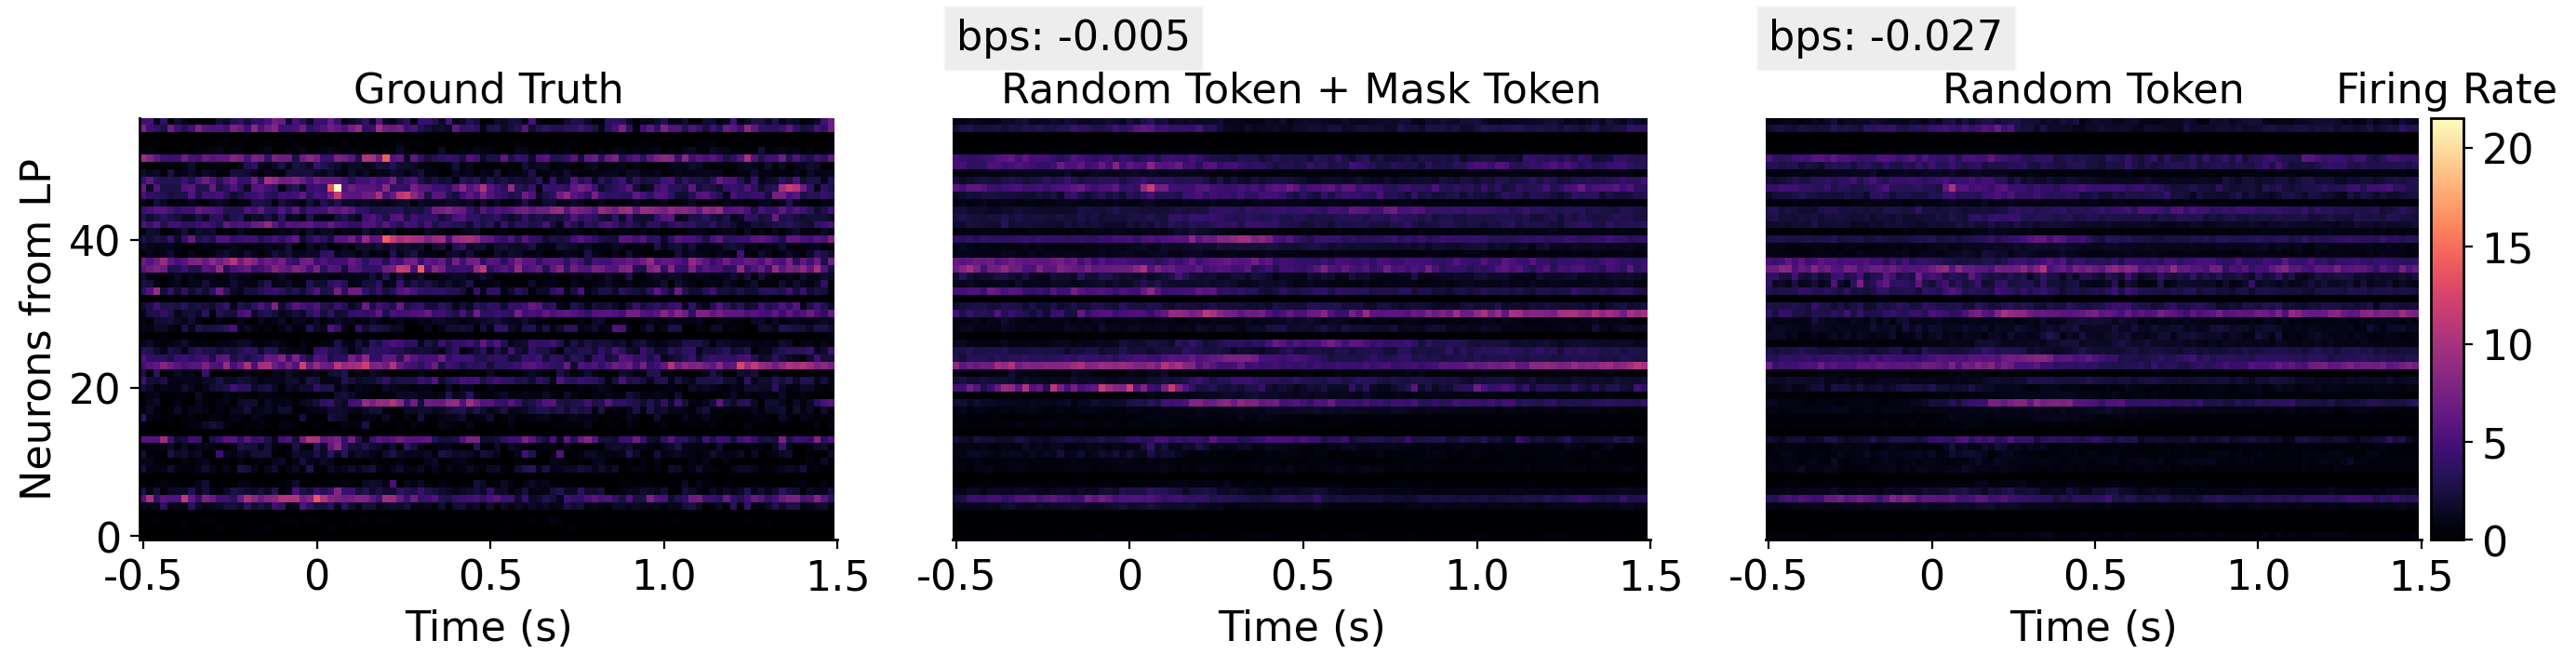

In [43]:
# inter-region

%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.patches as patches

bin_size = 0.02

gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size
display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

colormap = 'magma'

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Random Token') 
axes[1].set_title('Random Token + Mask Token') 
axes[0].set_ylabel('Neurons from LP')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 65.75, 'bps: -0.027', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 65.75, 'bps: -0.005', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))

plt.tight_layout()
plt.savefig(f'{work_dir}/notebooks/plots/inter_region_firing_rates_background.png', dpi=200)

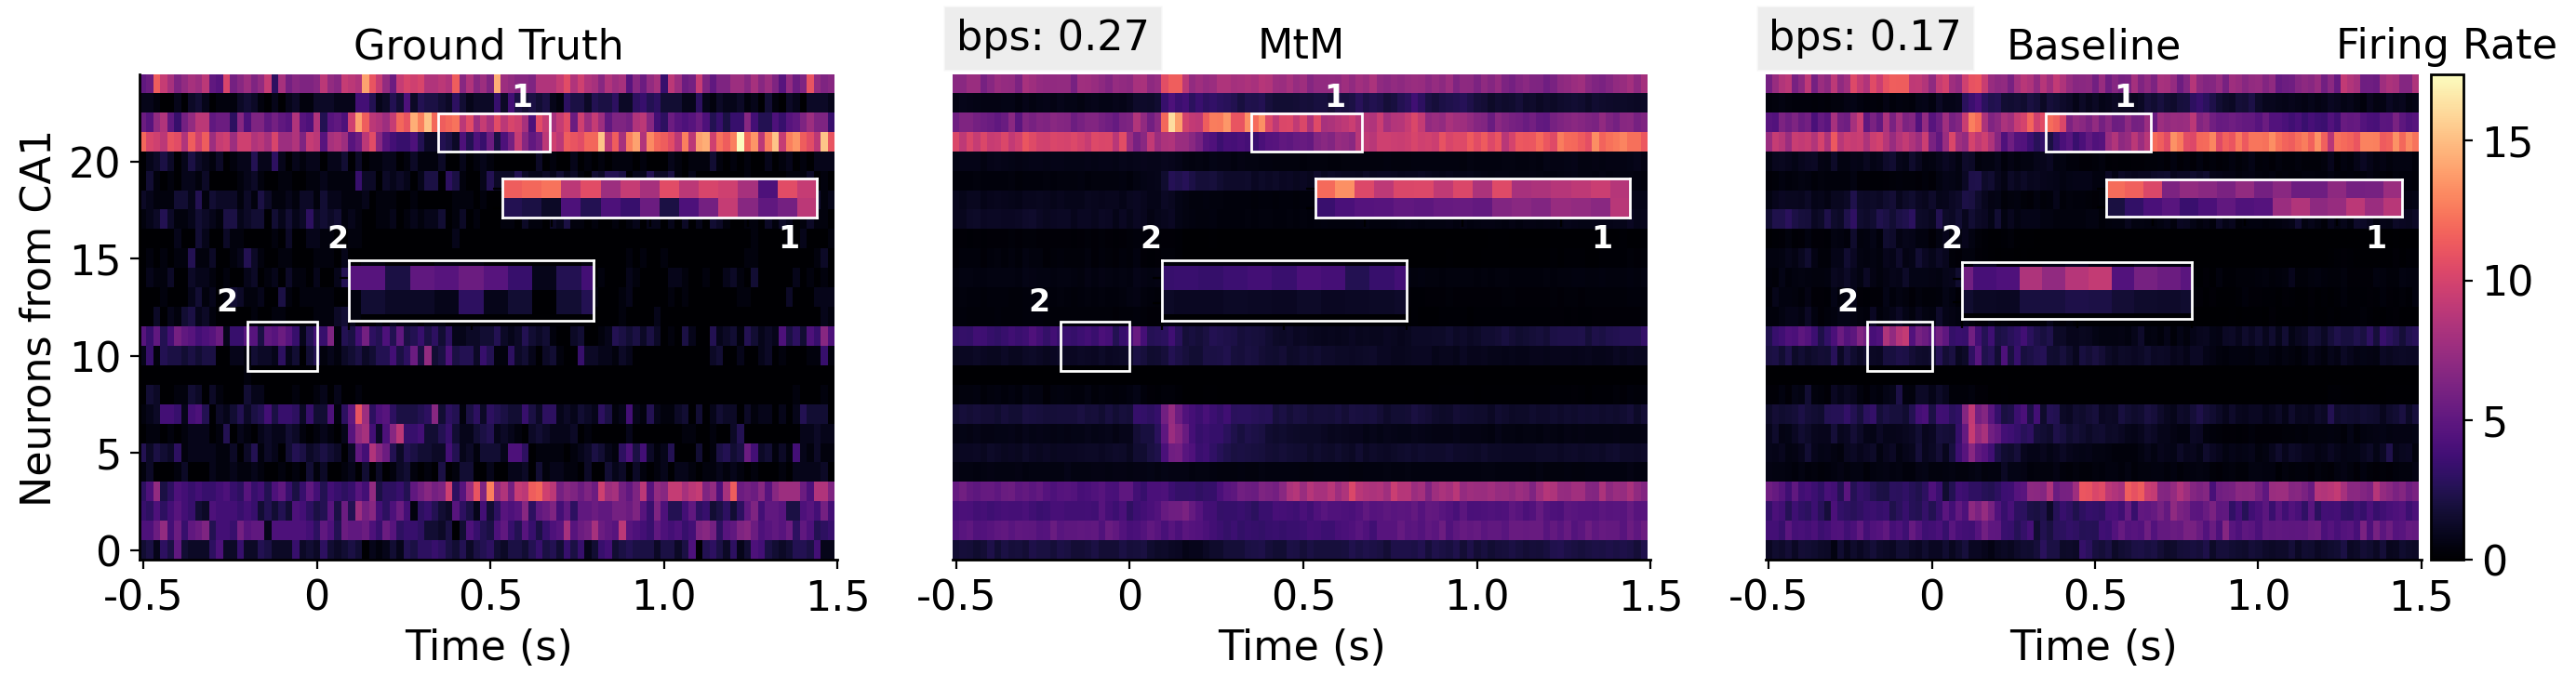

In [79]:
# inter-region

%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.patches as patches

bin_size = 0.02

gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size
display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

colormap = 'magma'

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Baseline') # (bps: -0.29)
axes[1].set_title('MtM') # bps: 0.39
axes[0].set_ylabel('Neurons from CA1')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 25.75, 'bps: 0.17', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 25.75, 'bps: 0.27', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 42.5, 58.5, 20.5, 22.5
    axins = ax.inset_axes(
        [0.52, 0.52, 0.45, 0.45],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    # mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 + 4
    cy = ry + rect.get_height() * 1.4
    ax.annotate('1', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('1', (93, 16), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')


for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 15, 25, 9.25, 11.75
    axins = ax.inset_axes(
        # [0.02, 0.55, 0.2, 0.2],
        [0.3, 0.38, .35, .35],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    # mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 - 8
    cy = ry + rect.get_height() * 1.4
    ax.annotate('2', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('2', (28, 16), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')

plt.tight_layout()
# plt.savefig(f'{work_dir}/notebooks/plots/inter_region_firing_rates_no_lines.png', dpi=100)

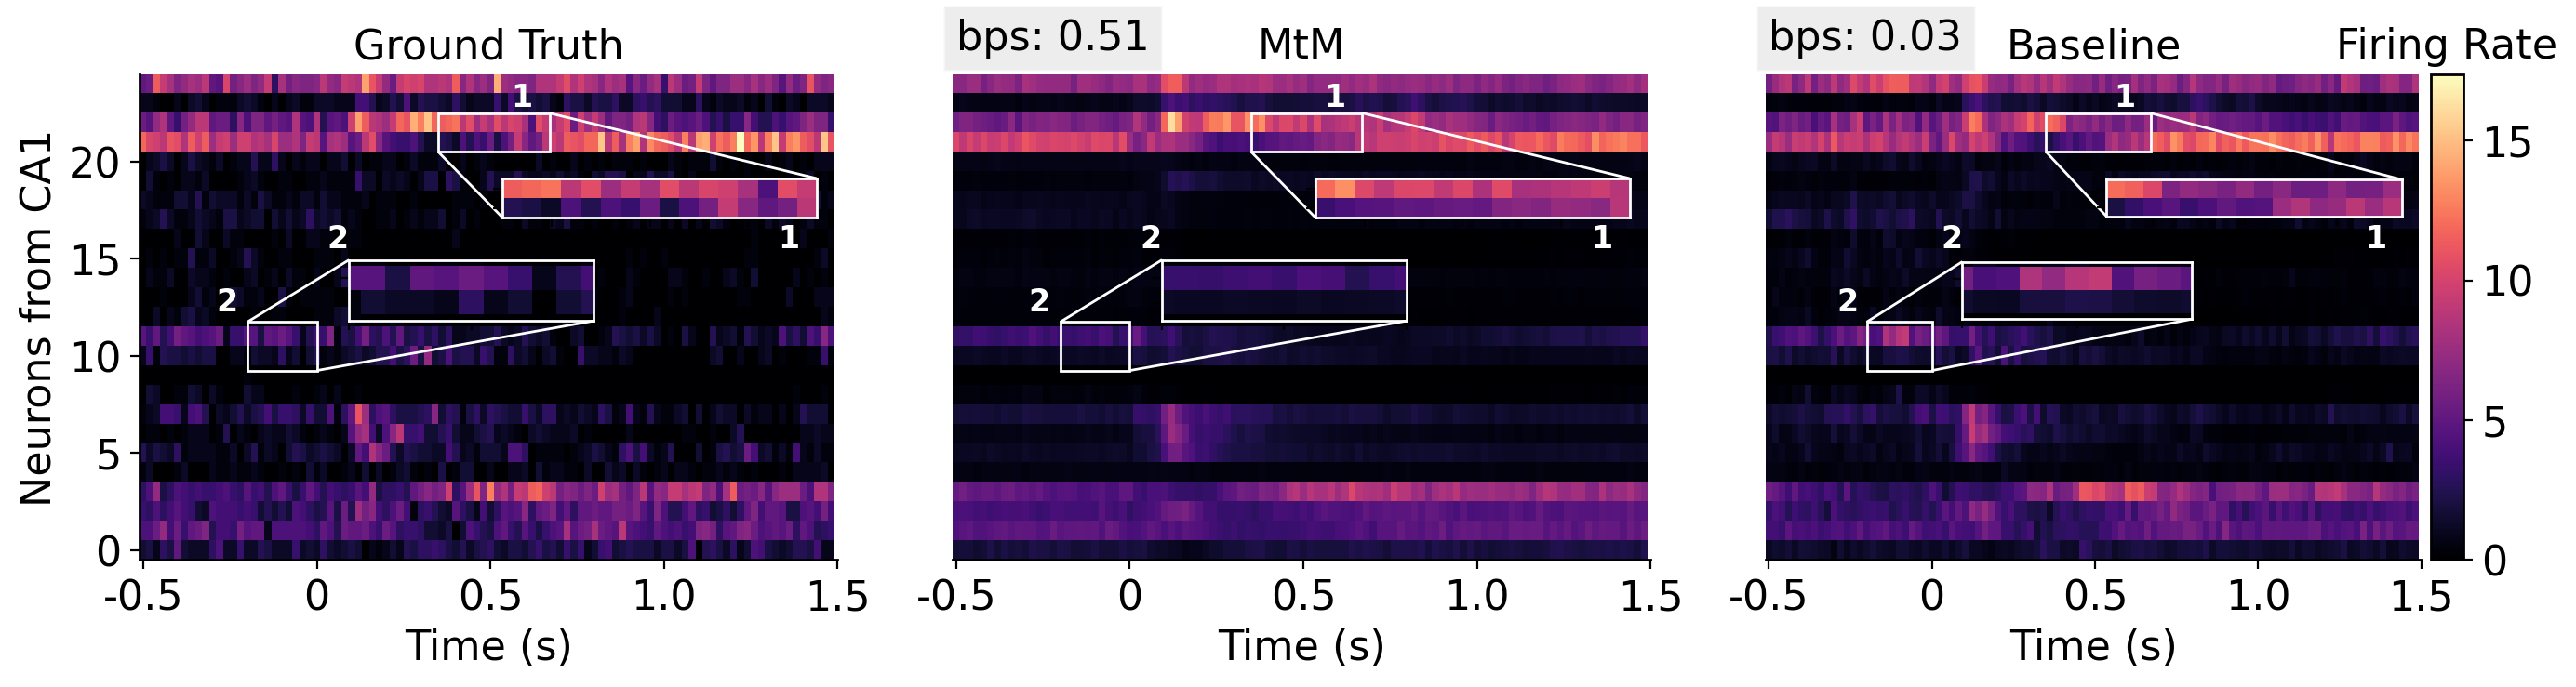

In [182]:
# inter-region

%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.patches as patches

bin_size = 0.02

gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size
display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

colormap = 'magma'

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Baseline') # (bps: -0.29)
axes[1].set_title('MtM') # bps: 0.39
axes[0].set_ylabel('Neurons from CA1')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 25.75, 'bps: 0.03', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 25.75, 'bps: 0.51', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 42.5, 58.5, 20.5, 22.5
    axins = ax.inset_axes(
        [0.52, 0.52, 0.45, 0.45],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    # ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 + 4
    cy = ry + rect.get_height() * 1.4
    ax.annotate('1', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('1', (93, 16), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')


for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 15, 25, 9.25, 11.75
    axins = ax.inset_axes(
        # [0.02, 0.55, 0.2, 0.2],
        [0.3, 0.38, .35, .35],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    # ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 - 8
    cy = ry + rect.get_height() * 1.4
    ax.annotate('2', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('2', (28, 16), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')

plt.tight_layout()
# plt.savefig(f'{work_dir}/notebooks/plots/inter_region_firing_rates.svg', dpi=400)

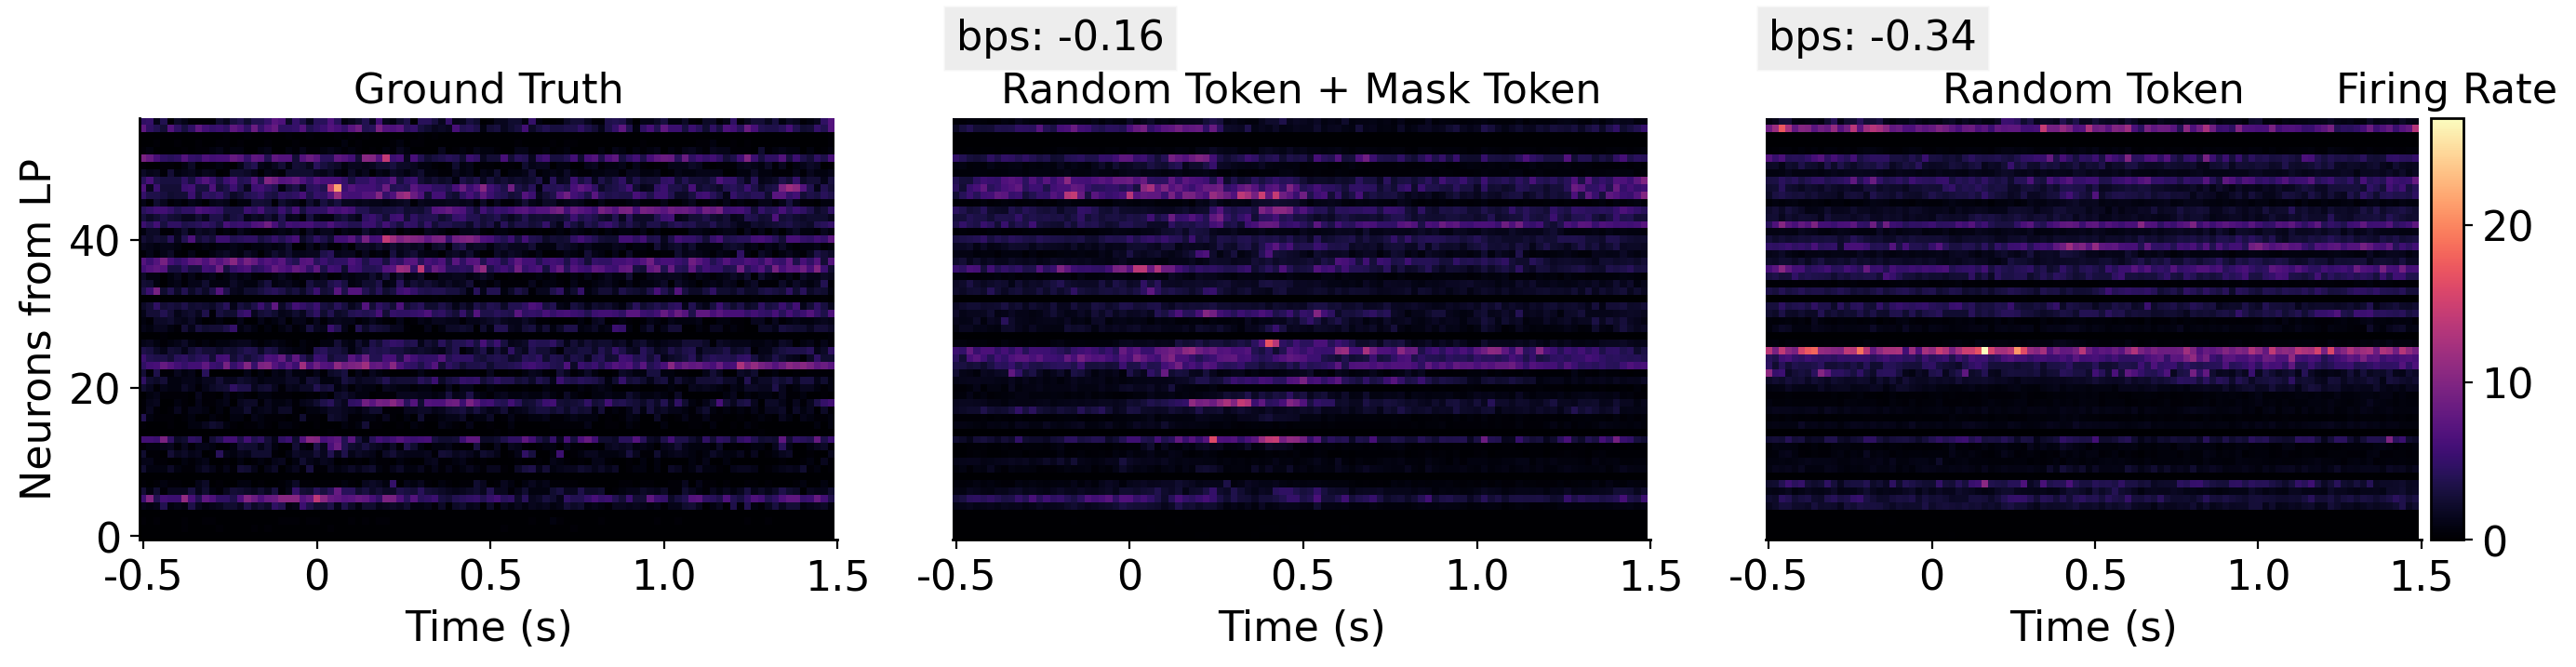

In [57]:
# intra-region
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.patches as patches

bin_size = 0.02

gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size
display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

colormap = 'magma'

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Random Token') 
axes[1].set_title('Random Token + Mask Token') 
axes[0].set_ylabel('Neurons from LP')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 65.75, 'bps: -0.34', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 65.75, 'bps: -0.16', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))

plt.tight_layout()
plt.savefig(f'{work_dir}/notebooks/plots/intra_region_firing_rates_background.png', dpi=200)

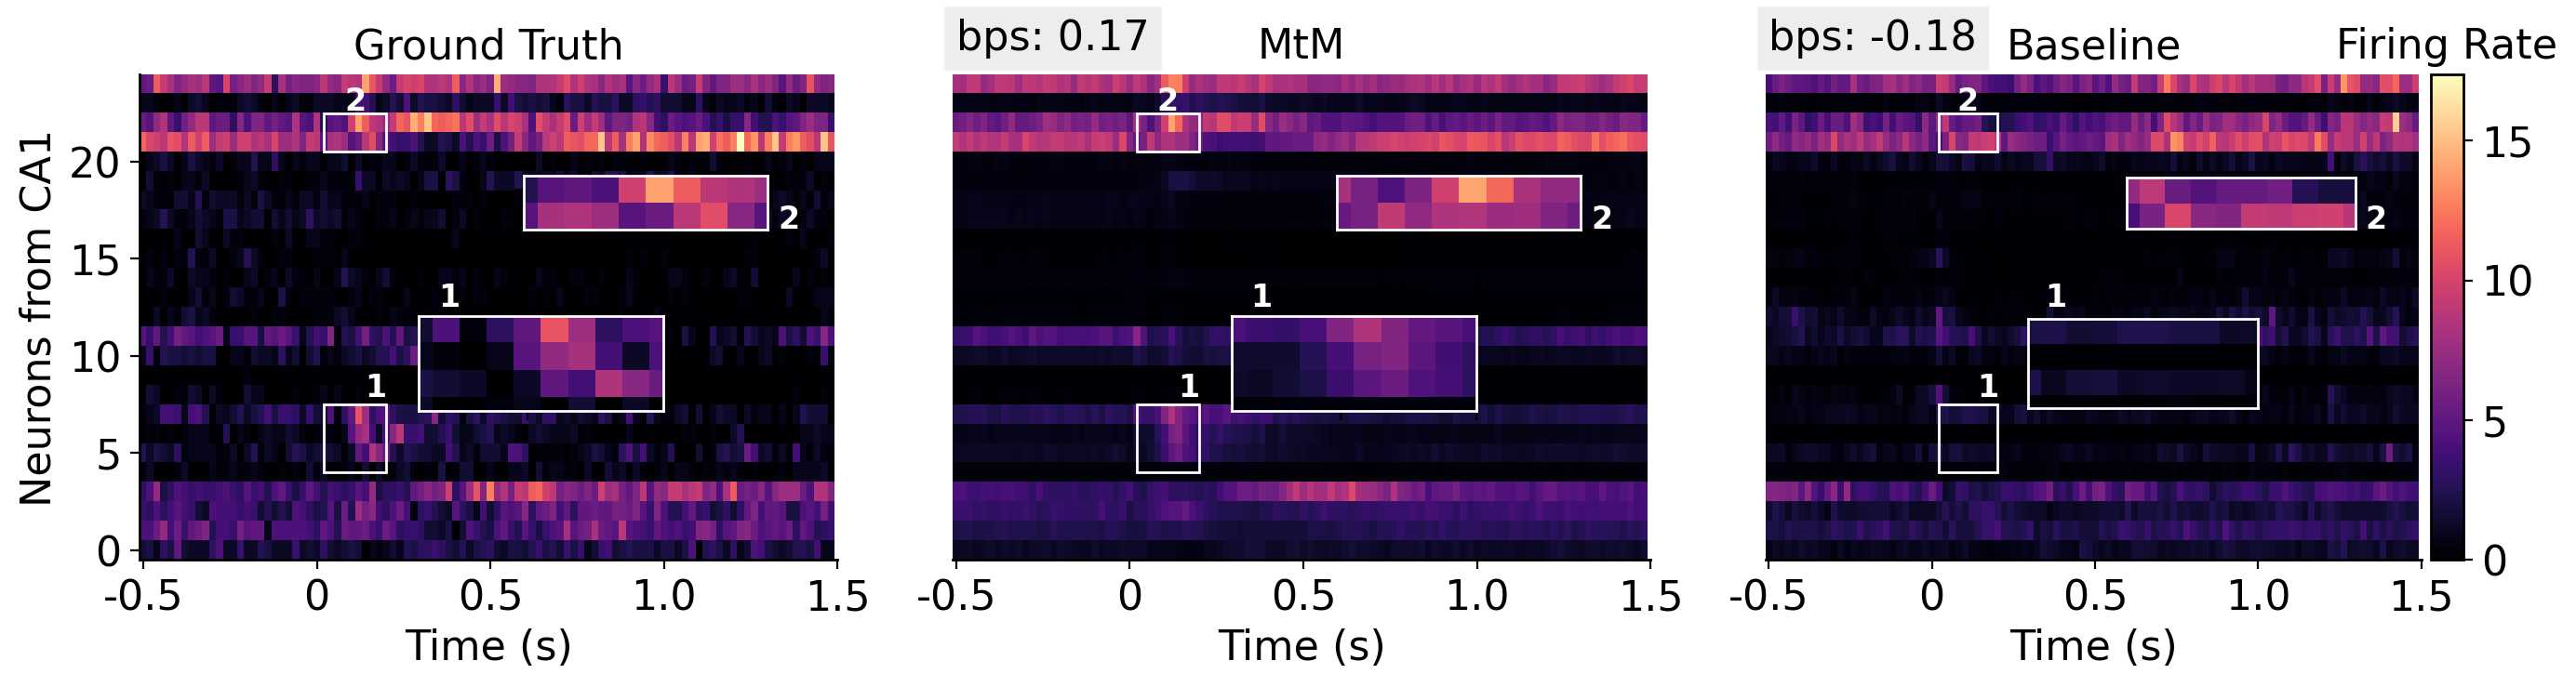

In [94]:
# intra-region
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.patches as patches

bin_size = 0.02

gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size
display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

colormap = 'magma'

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Baseline') # (bps: -0.29)
axes[1].set_title('MtM') # bps: 0.39
axes[0].set_ylabel('Neurons from CA1')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 25.75, 'bps: -0.18', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 25.75, 'bps: 0.17', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 26, 35, 4, 7.5
    axins = ax.inset_axes(
        [0.4, 0.23, 0.35, 0.35],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    # mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 + 3
    cy = ry + rect.get_height() * 1.25
    ax.annotate('1', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('1', (44, 13), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')


for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 26, 35, 20.5, 22.5
    axins = ax.inset_axes(
        # [0.02, 0.55, 0.2, 0.2],
        [0.55, 0.56, .35, .35],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    # mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="1", linestyle='-')
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 
    cy = ry + rect.get_height() * 1.3
    ax.annotate('2', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('2', (93, 17), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.savefig(f'{work_dir}/notebooks/plots/intra_region_firing_rates_no_lines.png', dpi=100)

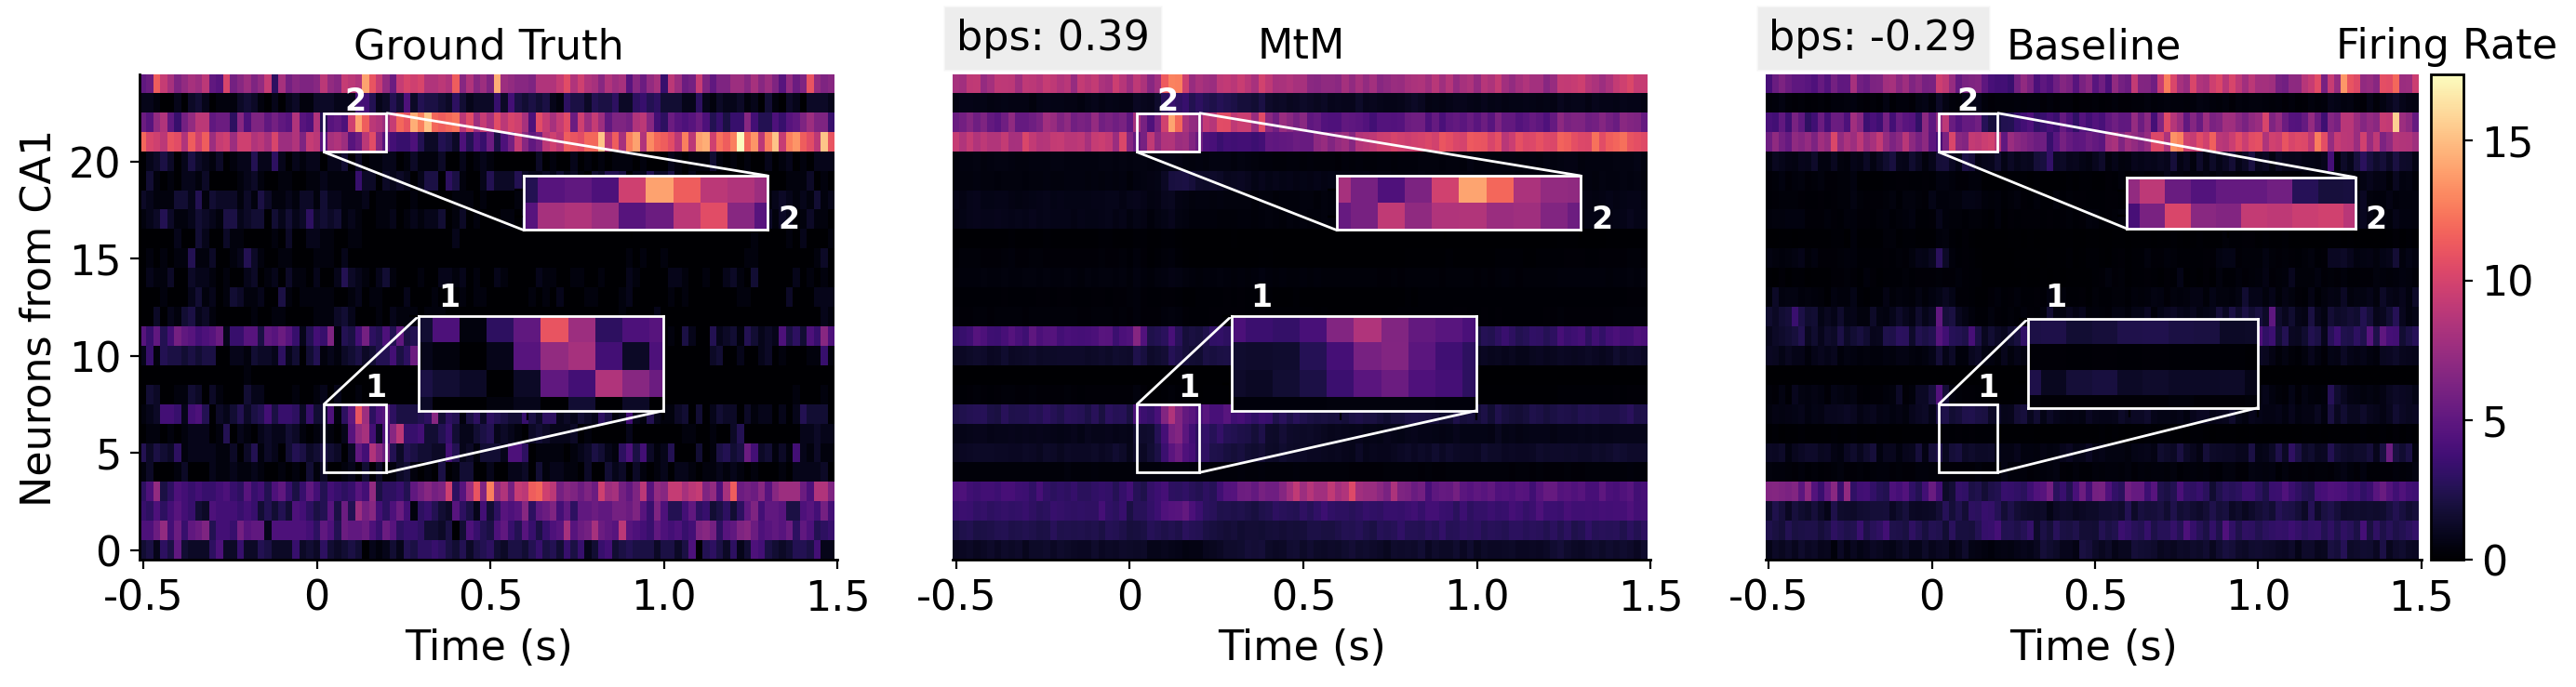

In [220]:
# intra-region
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import matplotlib.patches as patches

bin_size = 0.02

gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size
display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

colormap = 'magma'

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Baseline') # (bps: -0.29)
axes[1].set_title('MtM') # bps: 0.39
axes[0].set_ylabel('Neurons from CA1')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 25.75, 'bps: -0.29', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 25.75, 'bps: 0.39', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 26, 35, 4, 7.5
    axins = ax.inset_axes(
        [0.4, 0.23, 0.35, 0.35],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    # ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 + 3
    cy = ry + rect.get_height() * 1.25
    ax.annotate('1', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('1', (44, 13), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')


for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 26, 35, 20.5, 22.5
    axins = ax.inset_axes(
        # [0.02, 0.55, 0.2, 0.2],
        [0.55, 0.56, .35, .35],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="1", linestyle='-')
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    # ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 
    cy = ry + rect.get_height() * 1.3
    ax.annotate('2', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('2', (93, 17), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.savefig(f'{work_dir}/notebooks/plots/intra_region_firing_rates.svg', dpi=400)

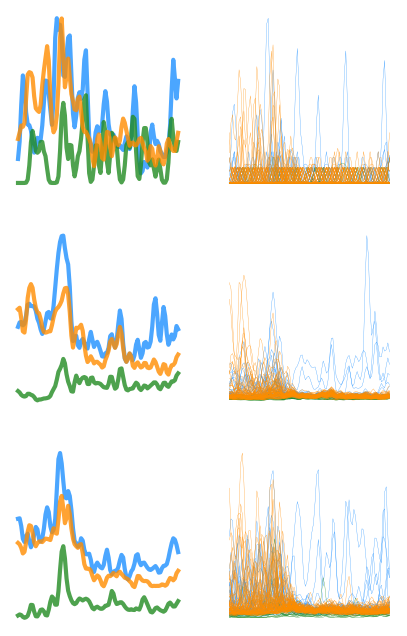

In [324]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

from scipy.ndimage import gaussian_filter1d

n_i = 1 # 7
sigma = 1.
gt = np.array([gaussian_filter1d(x, sigma) for x in gt_result[:,:,n_i]])
mtm = np.array([gaussian_filter1d(x, sigma) for x in mtm_result[:,:,n_i]])
temporal = np.array([gaussian_filter1d(x, sigma) for x in temporal_result[:,:,n_i]])
colors = ['dodgerblue', 'forestgreen', 'darkorange']

fig, axes = plt.subplots(3, 2, figsize=(5, 8))

for i, label in enumerate([0.2, 0.5, 0.8]):
    
    trial_idxs = (behavior_set[:,0,-1] == label)
    axes[0,0].plot(gt[trial_idxs].mean(0), color=colors[i], linewidth=3, alpha=.8)
    axes[0,1].plot(gt[trial_idxs].T, color=colors[i], alpha=.5, linewidth=.2)
    axes[0,0].set_ylabel('GT')
    axes[-1,0].plot(mtm[trial_idxs].mean(0), color=colors[i], linewidth=3, alpha=.8)
    axes[-1,1].plot(mtm[trial_idxs].T, color=colors[i], alpha=.5, linewidth=.2)
    axes[-1,0].set_ylabel('MtM')
    axes[1,0].plot(temporal[trial_idxs].mean(0), color=colors[i], linewidth=3, alpha=.8)
    axes[1,1].plot(temporal[trial_idxs].T, color=colors[i], alpha=.5, linewidth=.2)
    axes[1,0].set_ylabel('Baseline')
    for axs in axes:
        for ax in axs:
            ax.axis('off')

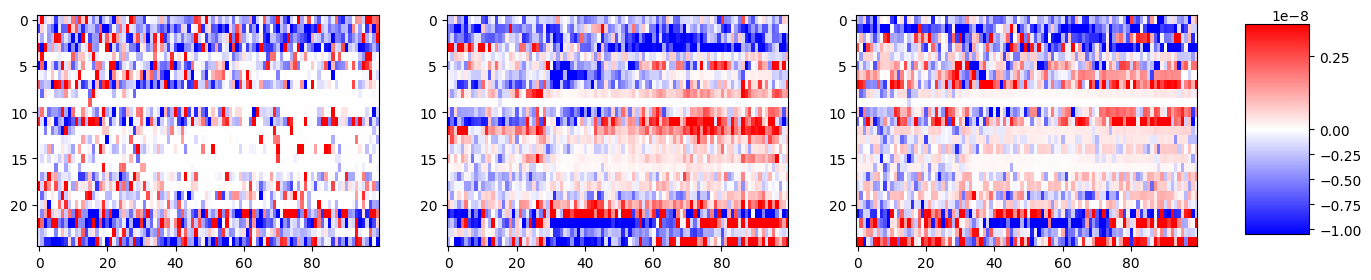

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])

vmin = np.percentile(y.mean(0), 5)
vmax = np.percentile(y.mean(0), 95)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im1 = axes[0].imshow(y.mean(0).T[t_sort], aspect='auto', cmap='bwr', norm=norm)

vmin = np.percentile(temporal_pred.mean(0), 5)
vmax = np.percentile(temporal_pred.mean(0), 95)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im2 = axes[1].imshow(temporal_pred.mean(0).T[t_sort], aspect='auto', cmap='bwr', norm=norm)

vmin = np.percentile(mtm_pred.mean(0), 5)
vmax = np.percentile(mtm_pred.mean(0), 95)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im3 = axes[2].imshow(mtm_pred.mean(0).T[t_sort], aspect='auto', cmap='bwr', norm=norm)

plt.colorbar(im1, cax=cbar_ax, pad=0.02, shrink=.6)

plt.savefig(f'{work_dir}/notebooks/plots/single_trial_psth_subtracted.png')

In [ ]:
bin_size = 0.02
gt_temp_resid = (gt_result - temporal_result).mean(0) / bin_size
gt_mtm_resid = (gt_result - mtm_result).mean(0) / bin_size
temp_mtm_resid = (temporal_result - mtm_result).mean(0) / bin_size

minmin = np.min([np.min(gt_temp_resid), np.min(gt_mtm_resid), np.min(temp_mtm_resid)])
maxmax = np.max([np.max(gt_temp_resid), np.max(gt_mtm_resid), np.max(temp_mtm_resid)])

minmin = -18
maxmax = 18

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
im1 = axes[0].imshow(gt_temp_resid.T, aspect='auto', cmap='RdBu_r', vmin=minmin, vmax=maxmax)
im2 = axes[1].imshow(gt_mtm_resid.T, aspect='auto', cmap='RdBu_r', vmin=minmin, vmax=maxmax)
im3 = axes[2].imshow(temp_mtm_resid.T, aspect='auto', cmap='RdBu_r', vmin=minmin, vmax=maxmax)
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Difference in\n Firing Rate')
axes[0].set_title('Residual (GT - Baseline)')
axes[1].set_title('Residual (GT - MtM)')
axes[2].set_title('Residual (Baseline - MtM)')
axes[0].set_ylabel('Neuron from CA1')
for ax in axes:
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
plt.savefig(f'{work_dir}/notebooks/plots/residual_firing_rates.png')

In [26]:
baseline_scatter = np.load(f'{work_dir}/notebooks/plots/{eid[:4]}/mask_temporal/inter_region/bps.npy')
mtm_scatter = np.load(f'{work_dir}/notebooks/plots/{eid[:4]}/mask_all/inter_region/bps.npy')

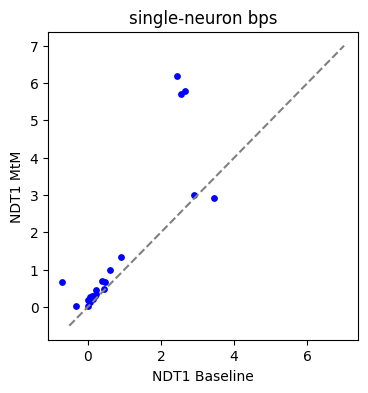

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(baseline_scatter, mtm_scatter, s=15, c='b')
ax.plot([-0.5, 7], [-0.5, 7], linestyle='--', c='grey')
ax.set_title('single-neuron bps')
ax.set_ylabel('NDT1 MtM')
ax.set_xlabel('NDT1 Baseline')
plt.savefig(f'{work_dir}/notebooks/plots/single_neuron_bps_scatters.png')

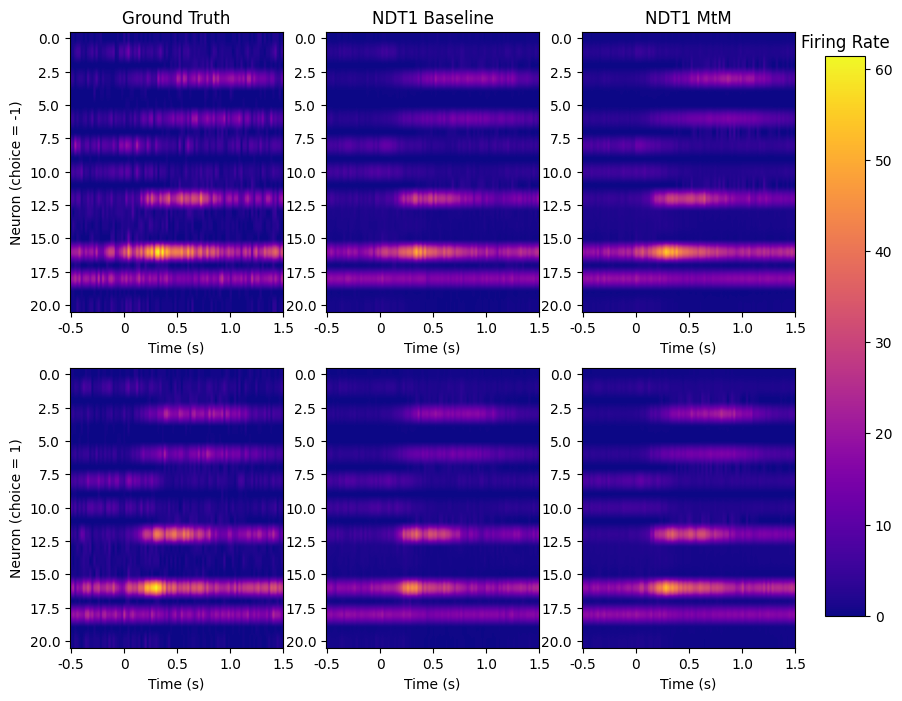

In [67]:
bin_size = 0.02

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])

for i, label in enumerate([-1,1]):
    
    trial_idxs = (behavior_set[:,0,0] == label)
    
    gt_mean = gt_result[trial_idxs].mean(0) / bin_size
    temporal_mean = temporal_result[trial_idxs].mean(0) / bin_size
    mtm_mean = mtm_result[trial_idxs].mean(0) / bin_size

    minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
    maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

    im1 = axes[i,0].imshow(gt_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    im2 = axes[i,1].imshow(temporal_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    im3 = axes[i,2].imshow(mtm_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    fig.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_title('Firing Rate')
    axes[0,0].set_title('Ground Truth')
    axes[0,1].set_title('NDT1 Baseline')
    axes[0,2].set_title('NDT1 MtM')
    axes[i,0].set_ylabel(f'Neuron (choice = {label})')
    for ax in axes[i]:
        ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
        ax.set_xlabel('Time (s)')
plt.savefig(f'{work_dir}/notebooks/plots/PSTH_choice.png')

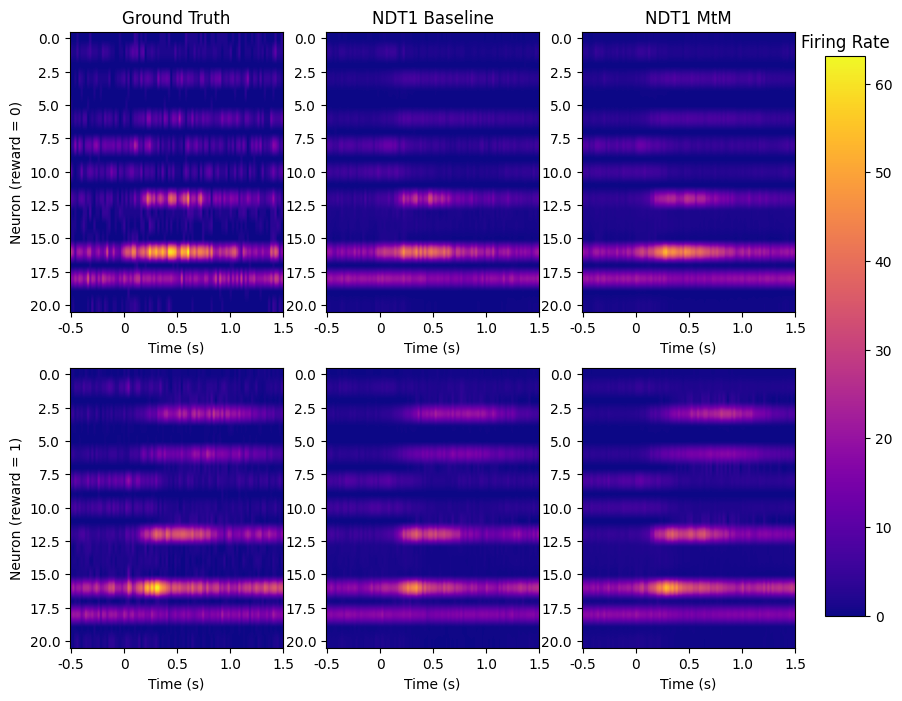

In [65]:
bin_size = 0.02

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])

for i, label in enumerate([0, 1]):
    
    trial_idxs = (behavior_set[:,0,1] == label)
    
    gt_mean = gt_result[trial_idxs].mean(0) / bin_size
    temporal_mean = temporal_result[trial_idxs].mean(0) / bin_size
    mtm_mean = mtm_result[trial_idxs].mean(0) / bin_size

    minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
    maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

    im1 = axes[i,0].imshow(gt_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    im2 = axes[i,1].imshow(temporal_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    im3 = axes[i,2].imshow(mtm_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    fig.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_title('Firing Rate')
    axes[0,0].set_title('Ground Truth')
    axes[0,1].set_title('NDT1 Baseline')
    axes[0,2].set_title('NDT1 MtM')
    axes[i,0].set_ylabel(f'Neuron (reward = {label})')
    for ax in axes[i]:
        ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
        ax.set_xlabel('Time (s)')
plt.savefig(f'{work_dir}/notebooks/plots/PSTH_reward.png')

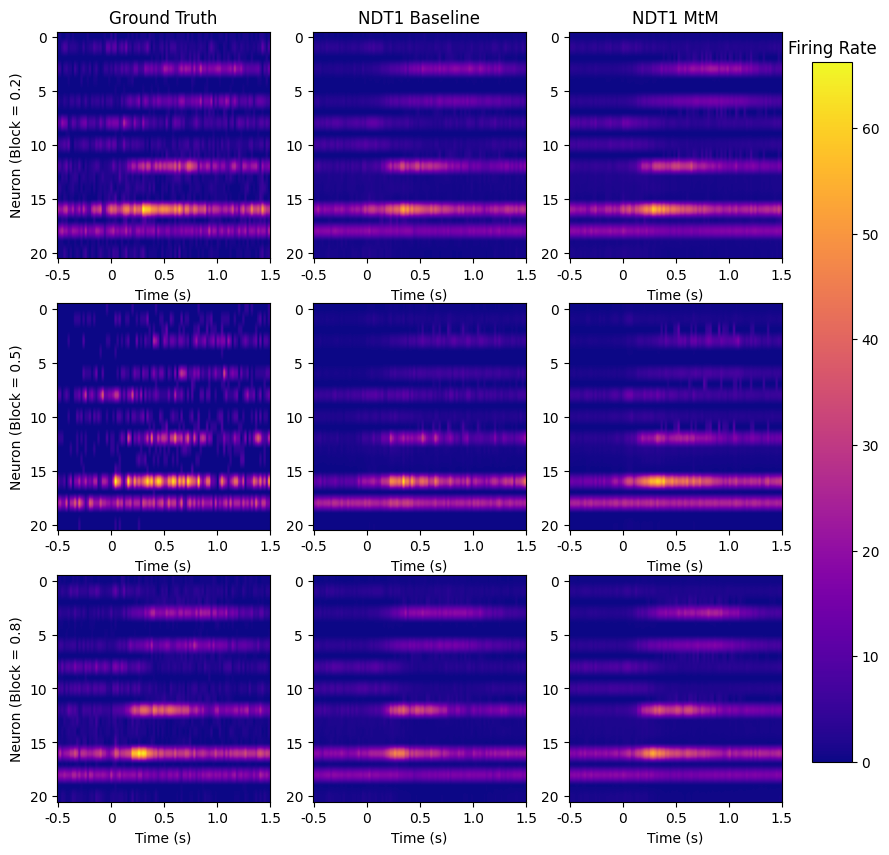

In [71]:
bin_size = 0.02

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])

for i, label in enumerate([0.2, 0.5, 0.8]):
    
    trial_idxs = (behavior_set[:,0,-1] == label)
    
    gt_mean = gt_result[trial_idxs].mean(0) / bin_size
    temporal_mean = temporal_result[trial_idxs].mean(0) / bin_size
    mtm_mean = mtm_result[trial_idxs].mean(0) / bin_size

    minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
    maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

    im1 = axes[i,0].imshow(gt_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    im2 = axes[i,1].imshow(temporal_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    im3 = axes[i,2].imshow(mtm_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
    fig.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_title('Firing Rate')
    axes[0,0].set_title('Ground Truth')
    axes[0,1].set_title('NDT1 Baseline')
    axes[0,2].set_title('NDT1 MtM')
    axes[i,0].set_ylabel(f'Neuron (Block = {label})')
    for ax in axes[i]:
        ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
        ax.set_xlabel('Time (s)')
plt.savefig(f'{work_dir}/notebooks/plots/PSTH_block.png')

### Neuron Co-Smoothing

In [73]:
base_path = '/expanse/lustre/scratch/yzhang39/temp_project'
eid = '824cf03d-4012-4ab1-b499-c83a92c5589e'
model_acroynm = 'ndt1'
model_name = 'NDT1'
mask_name = 'mask_all'
model_config = f"src/configs/{model_acroynm}/{model_acroynm}_prompting_eval.yaml"
mask_ratio = 0.3
best_ckpt_path = 'model_best.pt'

# Configuration
configs = {
    'model_config': model_config,
    'model_path': f'{base_path}/results/{eid}/train/model_{model_name}/method_ssl/{mask_name}/ratio_{mask_ratio}/mask_token_False/prompt_True/NEMO_False/no_channel_False/wvf_only_False/{best_ckpt_path}',
    'trainer_config': f'src/configs/{model_acroynm}/trainer_{model_acroynm}.yaml',
    'dataset_path': None, 
    'test_size': 0.2,
    'seed': 42,
    'mask_name': mask_name,
    'eid': eid,
    'stitching': False,
    'num_sessions': 1,
    'use_nemo': False,
    'wvf_only': False,
}  

In [75]:
# load your model and dataloader
model, accelerator, dataset, dataloader = load_model_data_local(**configs)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


seed set to 42
Total session-wise datasets found:  39
Loading train dataset sessions for predefined train/val/test split...


100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


session eid used:  {'824cf03d-4012-4ab1-b499-c83a92c5589e'}
Total number of session:  1
Train dataset size:  528
Val dataset size:  64
Test dataset size:  144
{'num_neurons': [401], 'num_sessions': 1, 'eids': {'824cf03d-4012-4ab1-b499-c83a92c5589e'}}
encoder max space length: 401
{'num_neurons': [401], 'num_sessions': 1, 'eids': {'824cf03d-4012-4ab1-b499-c83a92c5589e'}, 'max_space_length': 401}
(eval) masking mode:  all
(eval) masking ratio:  0.3
(eval) masking active:  False
len(dataset): 152
spike data shape: torch.Size([152, 100, 401])


In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': mask_name,
    'save_path': f'{work_dir}/notebooks/plots/{eid[:4]}/{mask_name}/co_smooth',
    'mode': 'per_neuron',
    'n_time_steps': 100,    
    'held_out_list': None,
    'is_aligned': True,
    'target_regions': ['all'],
    'n_jobs': 1
}
gt_result_list, pred_result_list, behavior_set = co_smoothing_eval(
    model, accelerator, dataloader, dataset, save_plot=True, **co_smoothing_configs
)

In [79]:
gt_result = np.stack(gt_result_list, -1)
mtm_result = np.stack(pred_result_list, -1)

In [80]:
base_path = '/expanse/lustre/scratch/yzhang39/temp_project'
eid = '824cf03d-4012-4ab1-b499-c83a92c5589e'
model_acroynm = 'ndt1'
model_name = 'NDT1'
mask_name = 'mask_temporal'
model_config = f"src/configs/{model_acroynm}/{model_acroynm}_eval.yaml"
mask_ratio = 0.3
best_ckpt_path = 'model_best.pt'

# Configuration
configs = {
    'model_config': model_config,
    'model_path': f'{base_path}/results/{eid}/train/model_{model_name}/method_ssl/{mask_name}/ratio_{mask_ratio}/mask_token_False/prompt_False/NEMO_False/no_channel_False/wvf_only_False/{best_ckpt_path}',
    'trainer_config': f'src/configs/{model_acroynm}/trainer_{model_acroynm}.yaml',
    'dataset_path': None, 
    'test_size': 0.2,
    'seed': 42,
    'mask_name': mask_name,
    'eid': eid,
    'stitching': False,
    'num_sessions': 1,
    'use_nemo': False,
    'wvf_only': False,
}  

In [81]:
# load your model and dataloader
model, accelerator, dataset, dataloader = load_model_data_local(**configs)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


seed set to 42
Total session-wise datasets found:  39
Loading train dataset sessions for predefined train/val/test split...


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


session eid used:  {'824cf03d-4012-4ab1-b499-c83a92c5589e'}
Total number of session:  1
Train dataset size:  528
Val dataset size:  64
Test dataset size:  144
{'num_neurons': [401], 'num_sessions': 1, 'eids': {'824cf03d-4012-4ab1-b499-c83a92c5589e'}}
encoder max space length: 401
{'num_neurons': [401], 'num_sessions': 1, 'eids': {'824cf03d-4012-4ab1-b499-c83a92c5589e'}, 'max_space_length': 401}
(eval) masking mode:  temporal
(eval) masking ratio:  0.3
(eval) masking active:  False
len(dataset): 152
spike data shape: torch.Size([152, 100, 401])


In [ ]:
co_smoothing_configs = {
    'subtract': 'task',
    'onset_alignment': [40],
    'method_name': mask_name,
    'save_path': f'{work_dir}/notebooks/plots/{eid[:4]}/{mask_name}/co_smooth',
    'mode': 'per_neuron',
    'n_time_steps': 100,    
    'held_out_list': None,
    'is_aligned': True,
    'target_regions': ['all'],
    'n_jobs': 1
}
_, pred_result_list, behavior_set = co_smoothing_eval(
    model, accelerator, dataloader, dataset, save_plot=True, **co_smoothing_configs
)

In [ ]:
temporal_result = np.stack(pred_result_list, -1).squeeze()

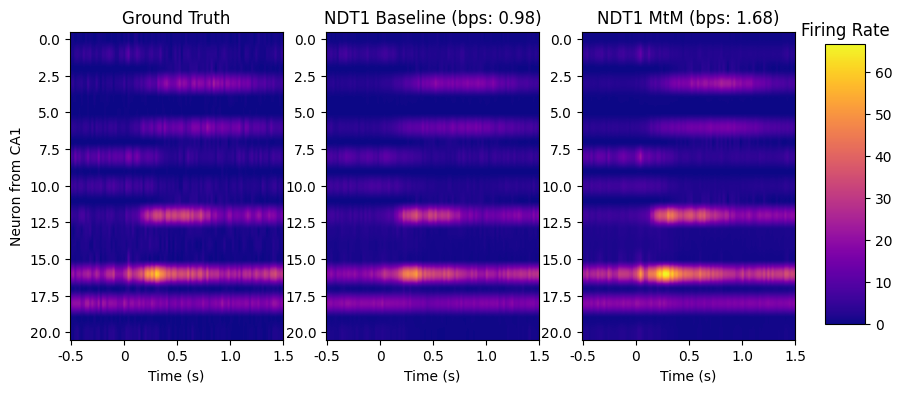

In [92]:
bin_size = 0.02
gt_mean = gt_result.mean(0) / bin_size
temporal_mean = temporal_result.mean(0) / bin_size
mtm_mean = mtm_result.mean(0) / bin_size

minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
im1 = axes[0].imshow(gt_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
im2 = axes[1].imshow(temporal_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
im3 = axes[2].imshow(mtm_mean.T, aspect='auto', cmap='plasma', vmin=minmin, vmax=maxmax)
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[1].set_title('NDT1 Baseline (bps: 0.98)')
axes[2].set_title('NDT1 MtM (bps: 1.68)')
axes[0].set_ylabel('Neuron from CA1')
for ax in axes:
    ax.set_xticks([0, 25, 50, 75, 100], [-0.5, 0, 0.5, 1., 1.5])
    ax.set_xlabel('Time (s)')
plt.savefig(f'{work_dir}/notebooks/plots/co_smooth_raster_mapspng.png')

### 3. Intra-Region Prediction
- using `co_smoothing_r2` with mode `intra_region` for r2 and psth/residual plots.
- using `co_smoothing_bps` with mode `intra_region` for co-bps stat.